# Telco Churn Prediction

## Task 1: Exploratory Data Analysis

### Step 1: Capture the numeric and categorical variables.

In [567]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [568]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [569]:
def check_df(dataframe, head = 5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.head(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.95, 0.99, 1]).T)

In [570]:
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0  7590-VHVEG  Female              0     Yes         No       1    

In [571]:
def grab_col_names(dataframe, categorical_threshold = 10, cardinal_threshold = 20):
    categorical_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    
    numeric_looking_but_categorical = [col for col in dataframe.columns if dataframe[col].dtype != "O" and dataframe[col].nunique() < categorical_threshold]
    
    categorical_looking_but_cardinal = [col for col in dataframe.columns  if dataframe[col].dtype == "O" and dataframe[col].nunique() > cardinal_threshold]
    
    categorical_cols = categorical_cols + numeric_looking_but_categorical
    
    categorical_cols = [col for col in categorical_cols if col not in categorical_looking_but_cardinal]
    
    numeric_cols = [col for col in dataframe.columns if dataframe[col].dtype != "O"]
    
    numeric_cols = [col for col in numeric_cols if col not in numeric_looking_but_categorical]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"Categorical Columns: {len(categorical_cols)}")
    print(f"Numeric Columns: {len(numeric_cols)}")
    print(f"Categorical Looking but Cardinal: {len(categorical_looking_but_cardinal)}")
    print(f"Numeric Looking but Categorical: {len(numeric_looking_but_categorical)}")
    return categorical_cols, numeric_cols, categorical_looking_but_cardinal
    

In [572]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
Categorical Columns: 17
Numeric Columns: 2
Categorical Looking but Cardinal: 2
Numeric Looking but Categorical: 1


### Step 2: Make the necessary adjustments. (Like variables with type errors)

In [573]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [574]:
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

### Step 3: Observe the distribution of numerical and categorical variables in the data.

In [575]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
Categorical Columns: 17
Numeric Columns: 3
Categorical Looking but Cardinal: 1
Numeric Looking but Categorical: 2


In [576]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Churn']

In [577]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [578]:
cat_but_car

['customerID']

In [579]:
def categorical_summary(dataframe, col_name, plot = False):
    print(pd.DataFrame({col_name : dataframe[col_name].value_counts(),
                       "Ratio" : dataframe[col_name].value_counts()/ len(dataframe)}))
    
    if plot: 
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show(block=True)

        gender  Ratio
Male      3555  0.505
Female    3488  0.495


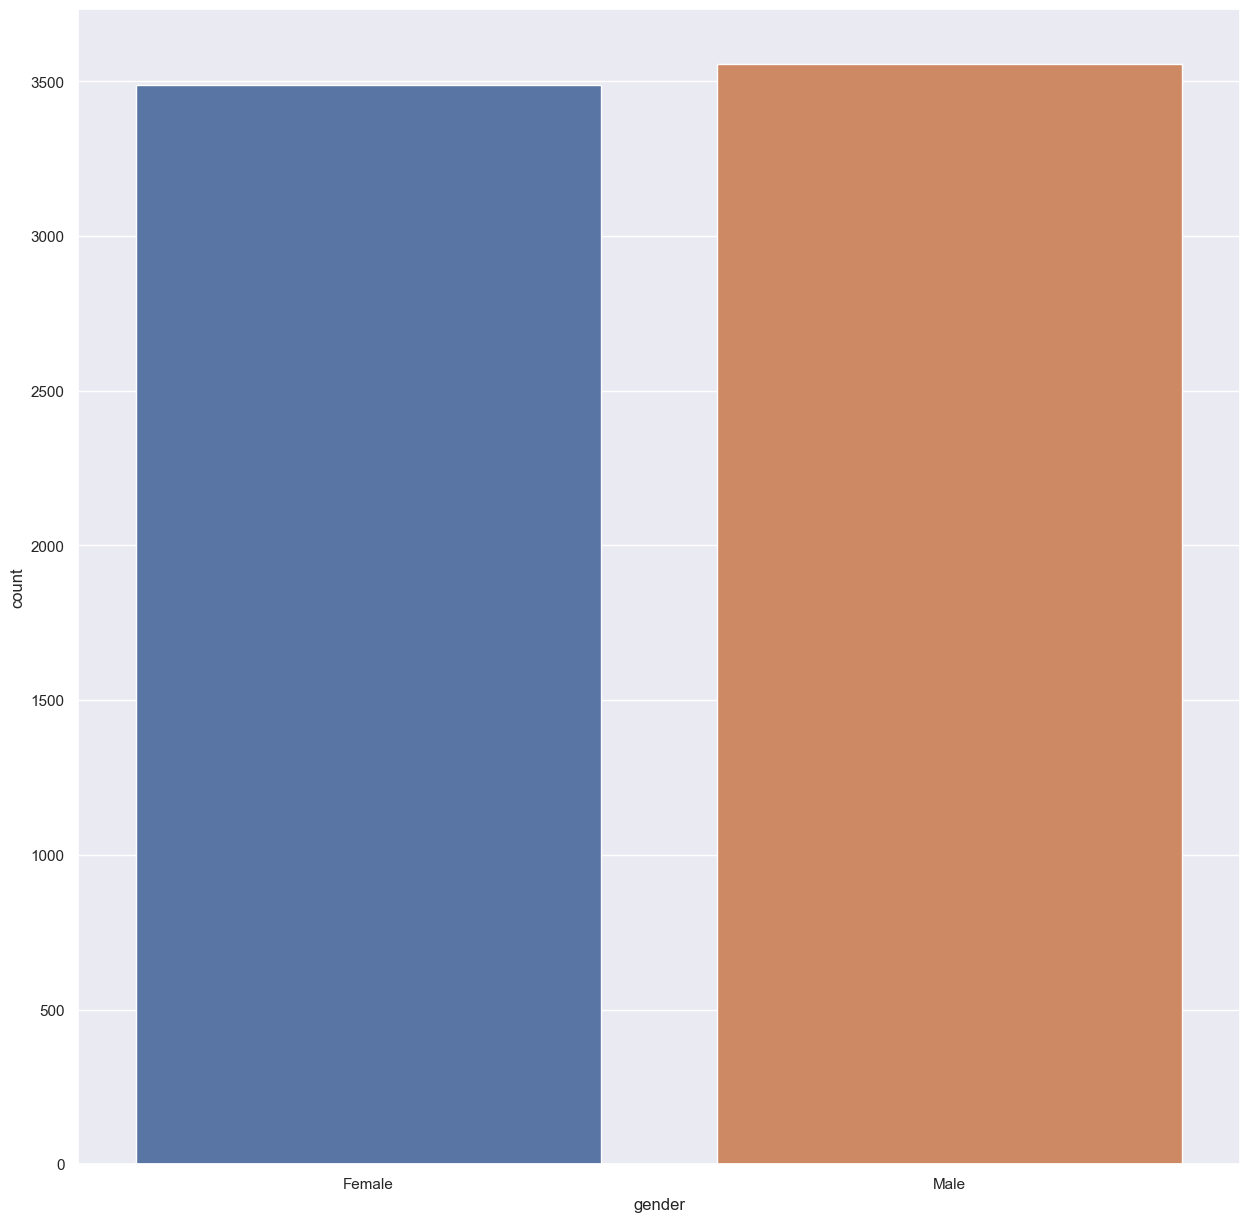

     Partner  Ratio
No      3641  0.517
Yes     3402  0.483


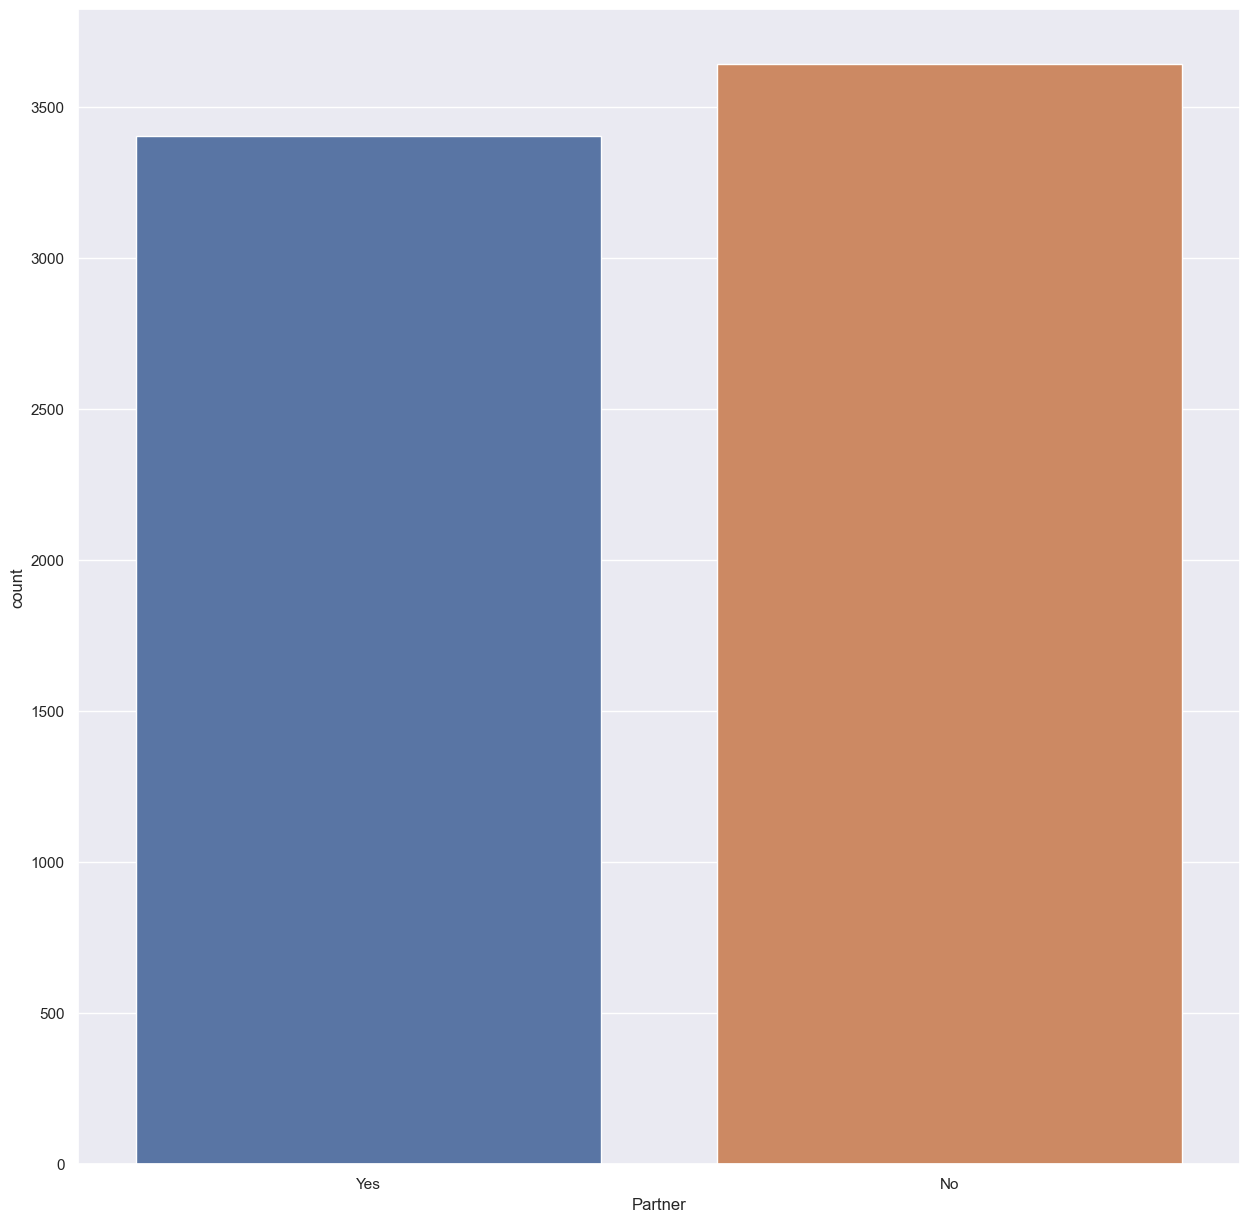

     Dependents  Ratio
No         4933  0.700
Yes        2110  0.300


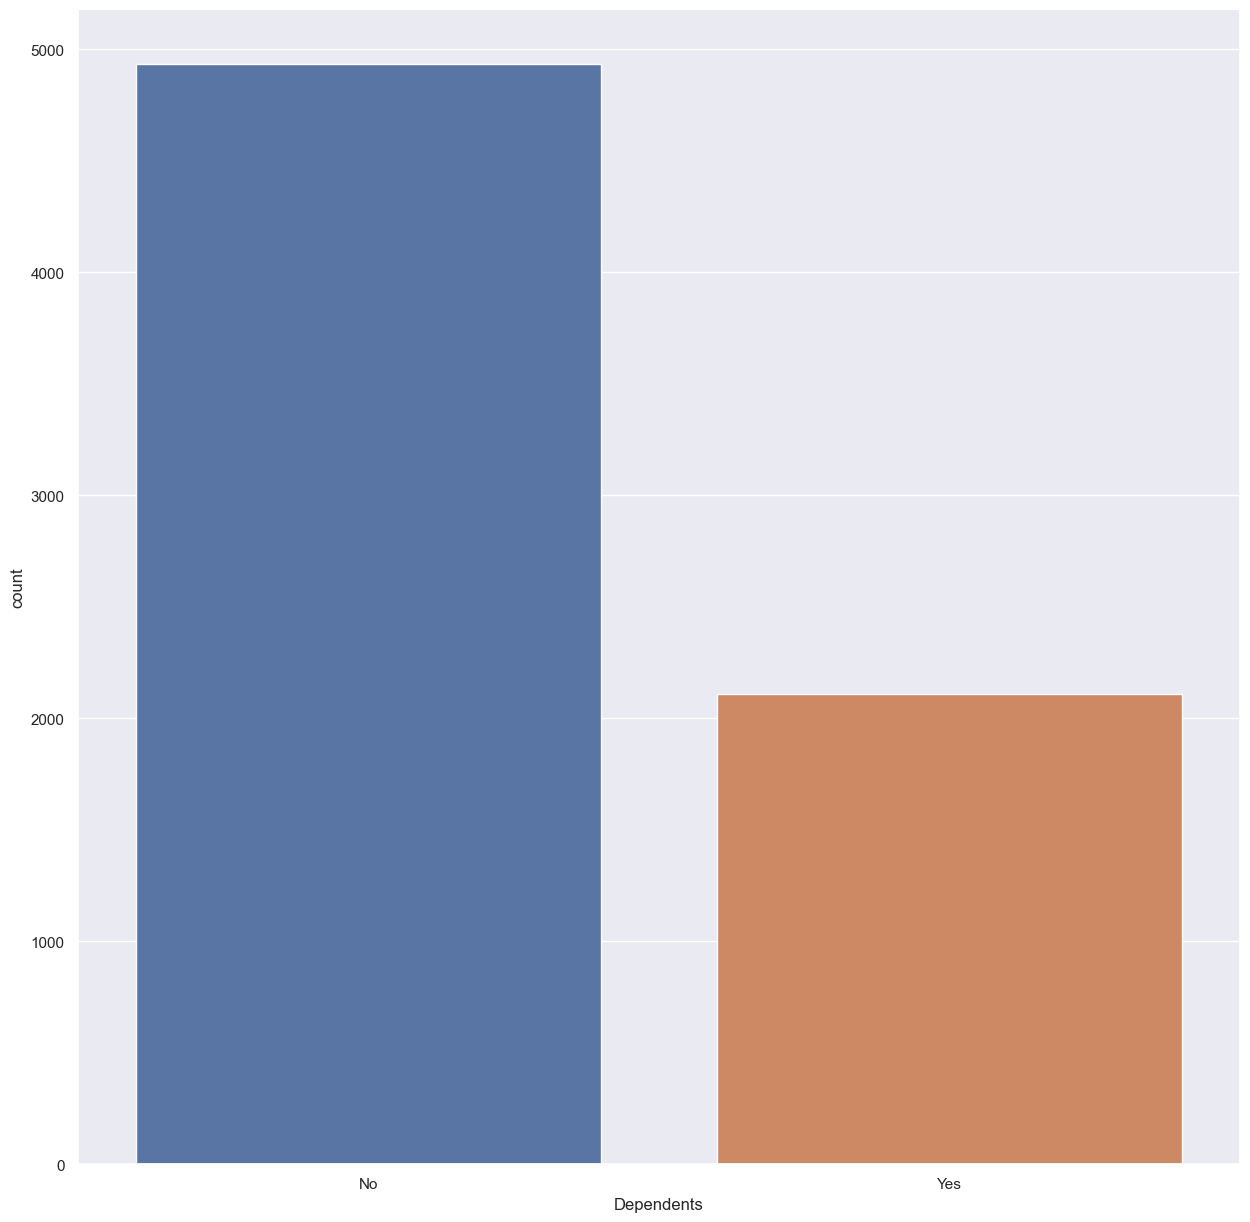

     PhoneService  Ratio
Yes          6361  0.903
No            682  0.097


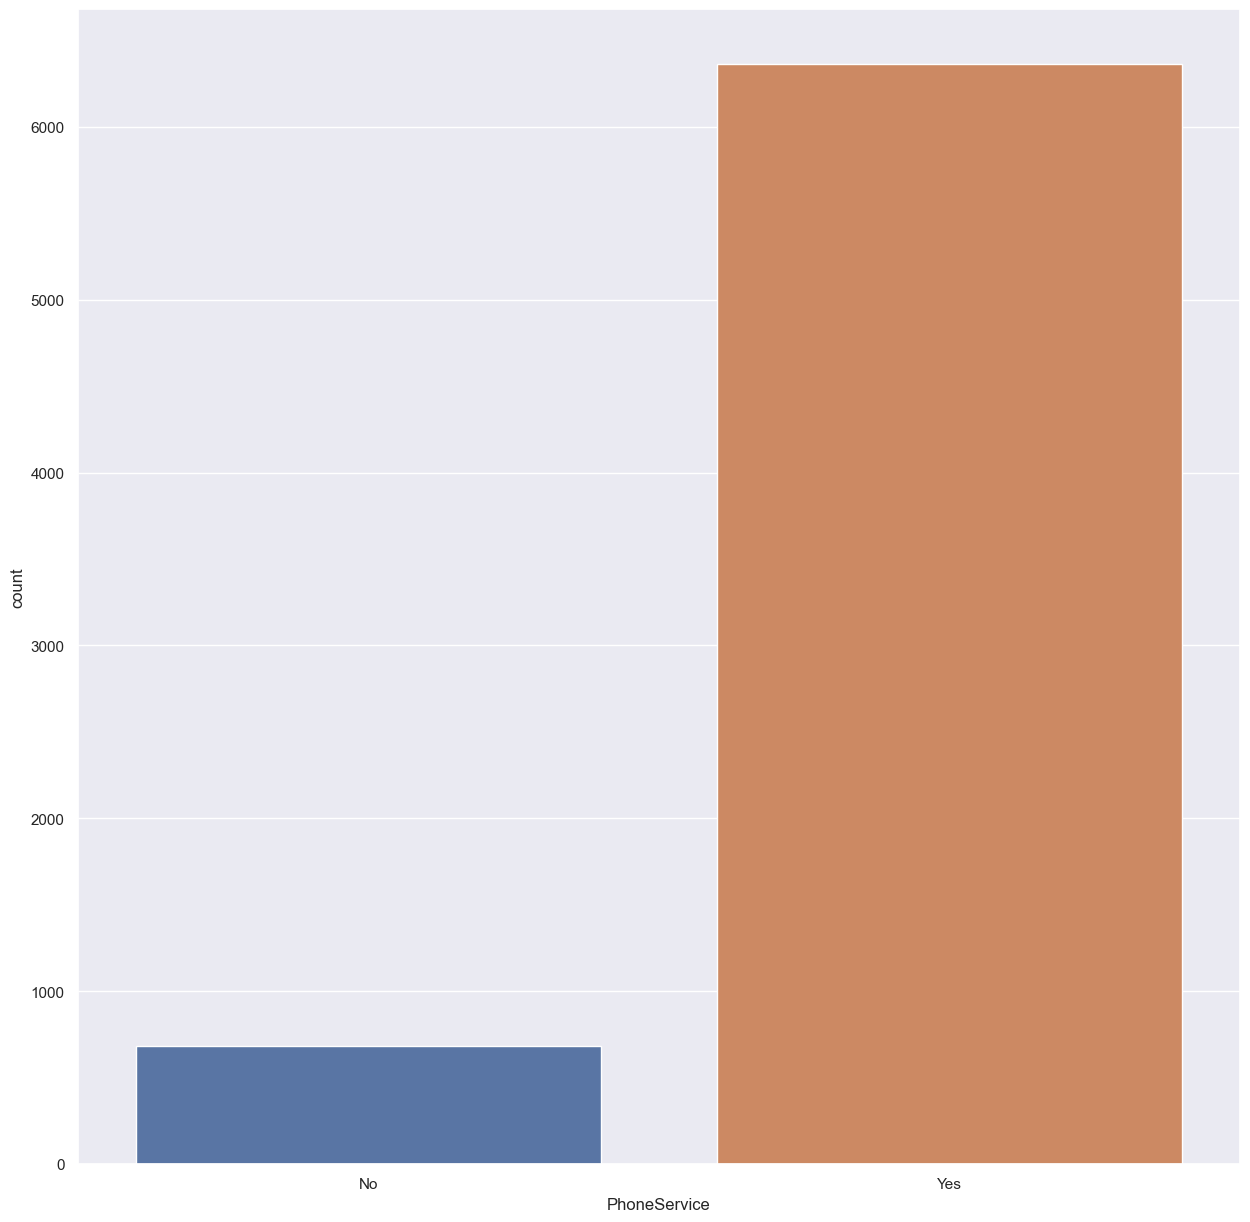

                  MultipleLines  Ratio
No                         3390  0.481
Yes                        2971  0.422
No phone service            682  0.097


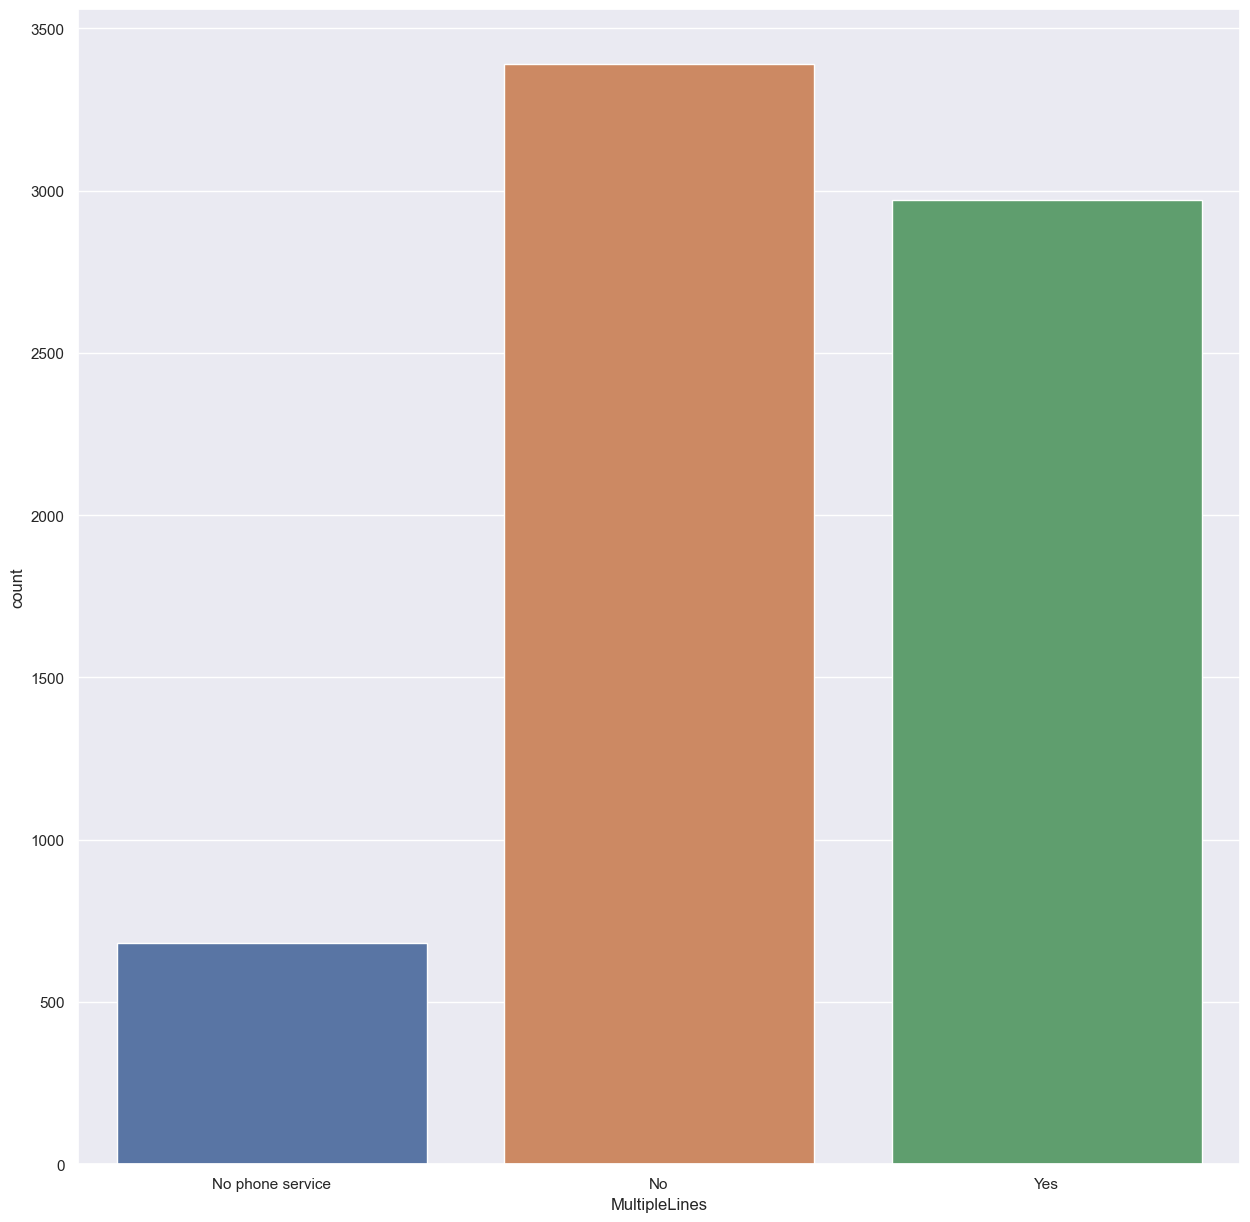

             InternetService  Ratio
Fiber optic             3096  0.440
DSL                     2421  0.344
No                      1526  0.217


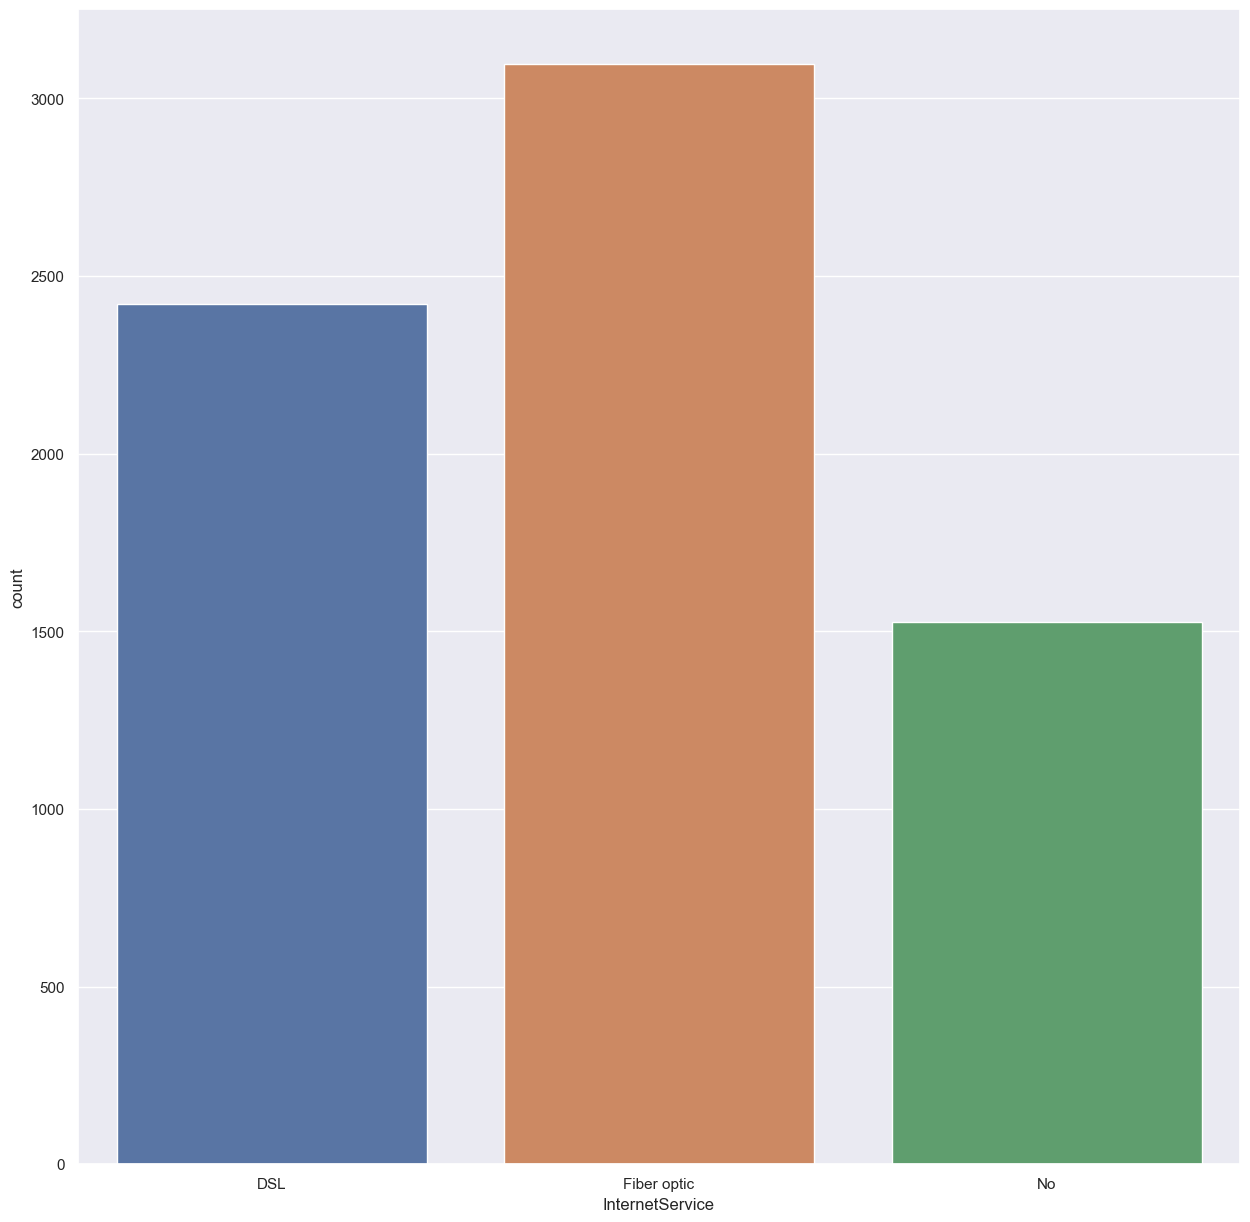

                     OnlineSecurity  Ratio
No                             3498  0.497
Yes                            2019  0.287
No internet service            1526  0.217


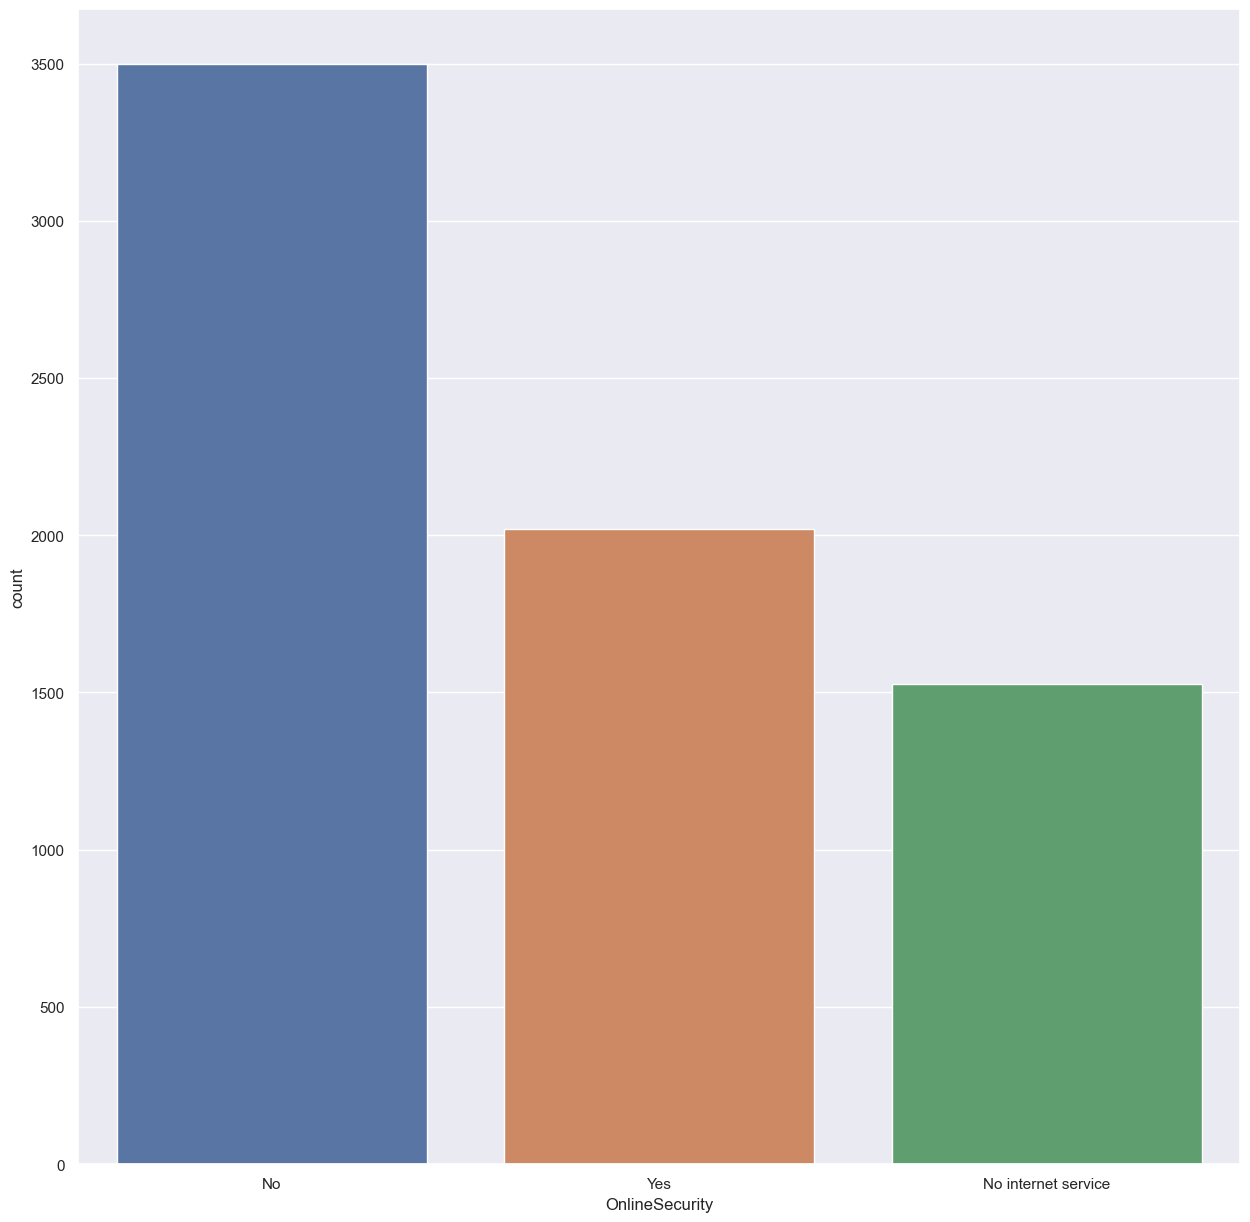

                     OnlineBackup  Ratio
No                           3088  0.438
Yes                          2429  0.345
No internet service          1526  0.217


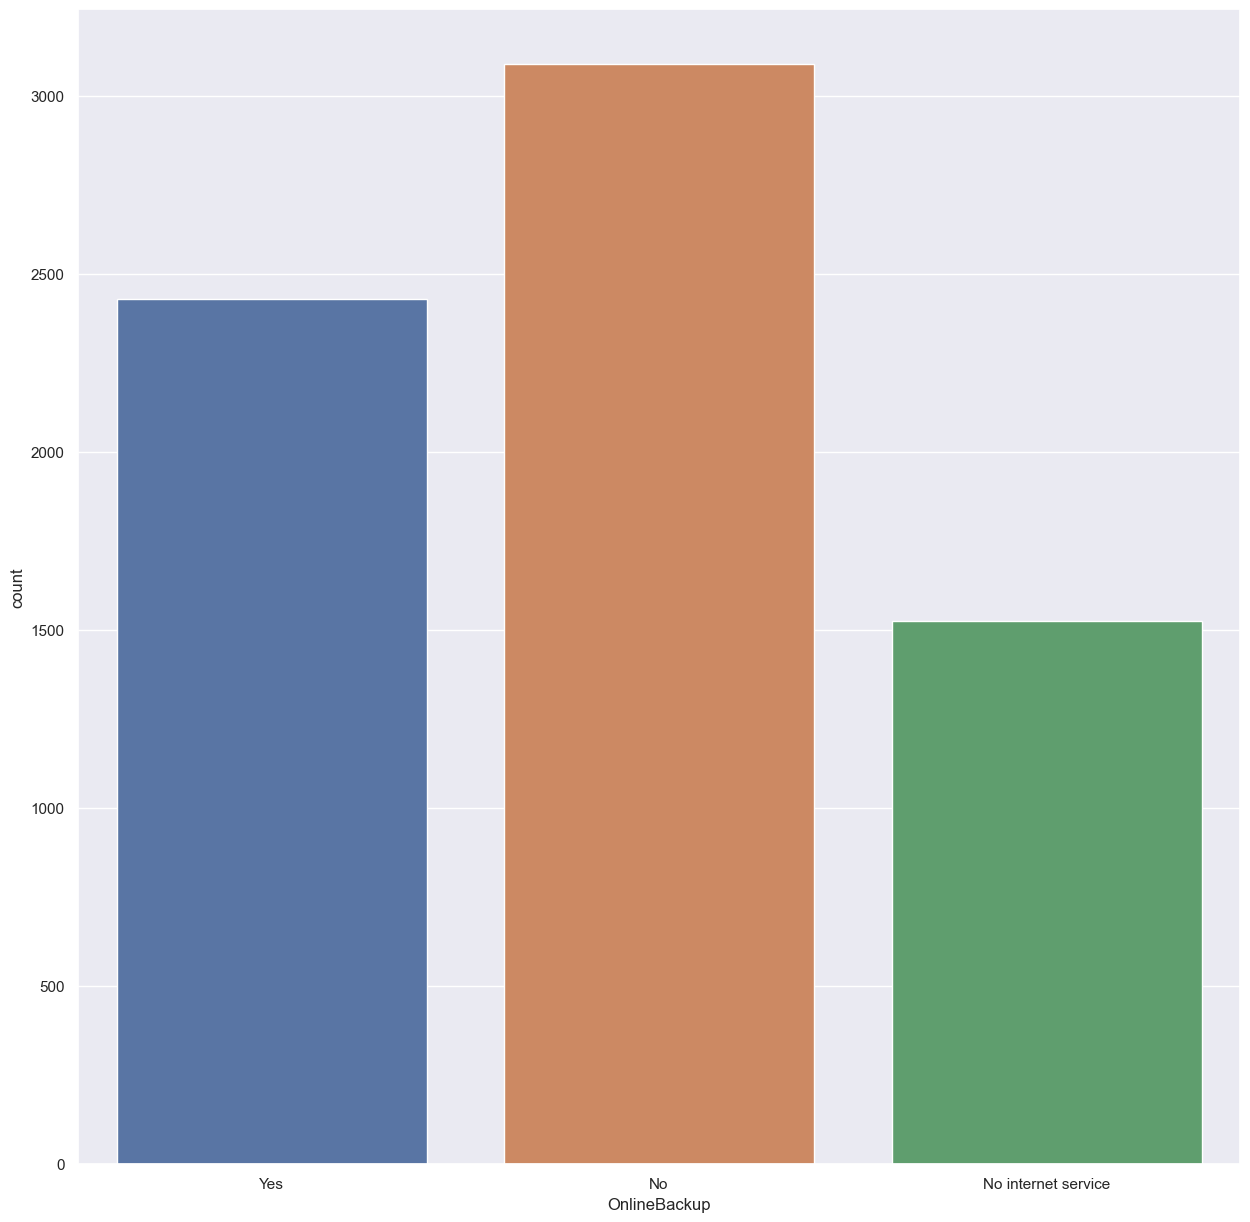

                     DeviceProtection  Ratio
No                               3095  0.439
Yes                              2422  0.344
No internet service              1526  0.217


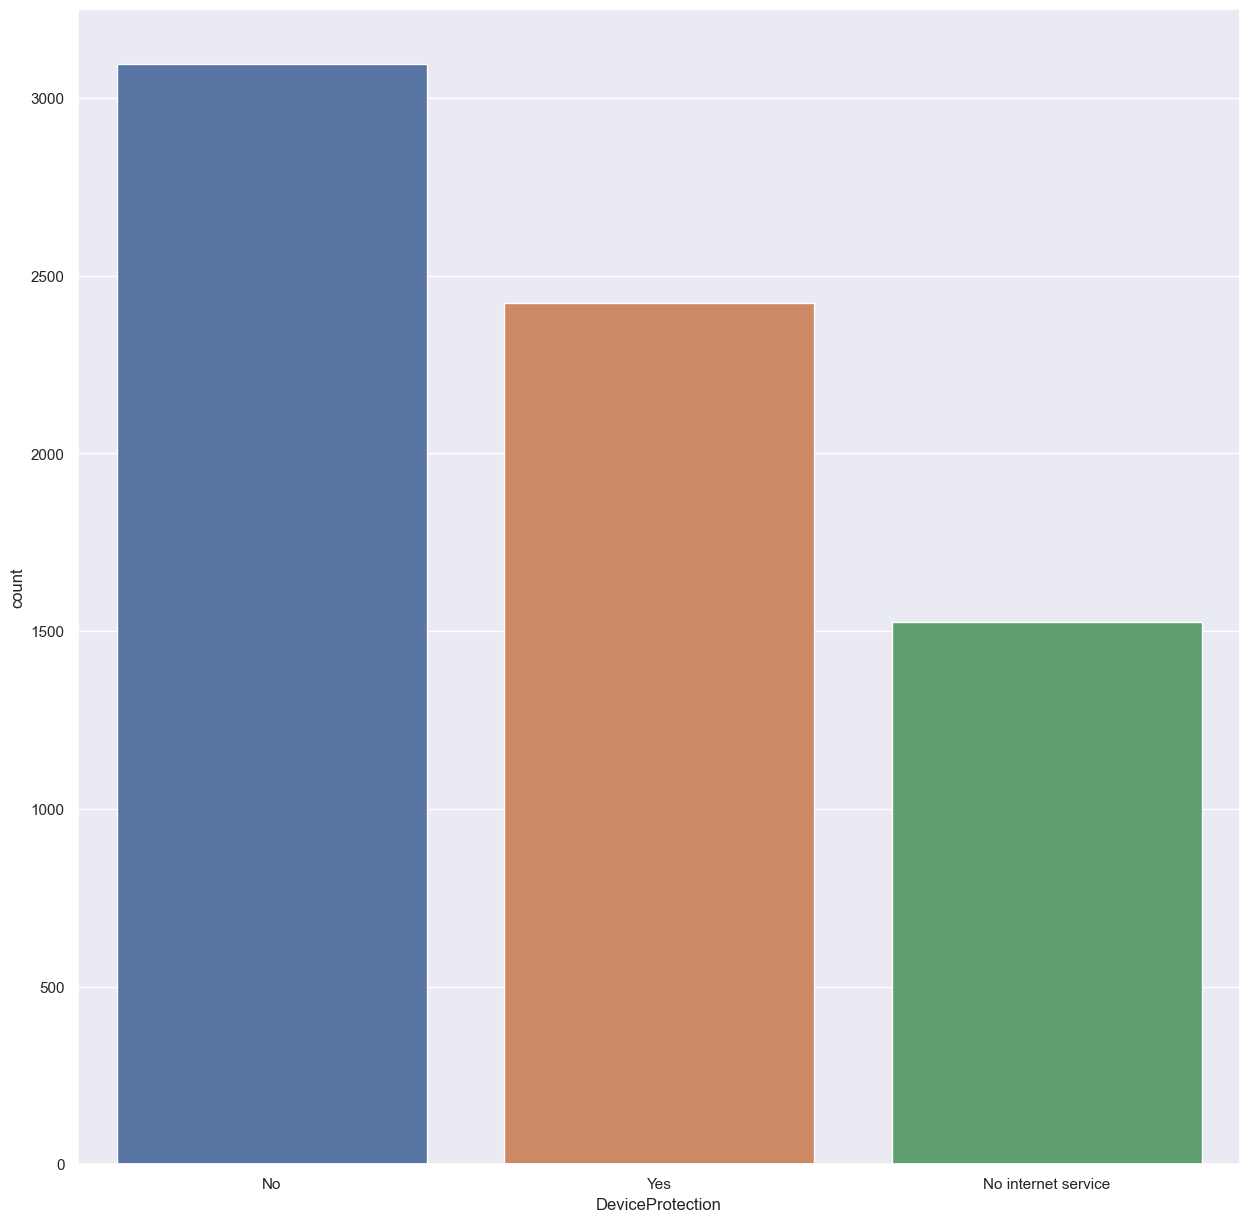

                     TechSupport  Ratio
No                          3473  0.493
Yes                         2044  0.290
No internet service         1526  0.217


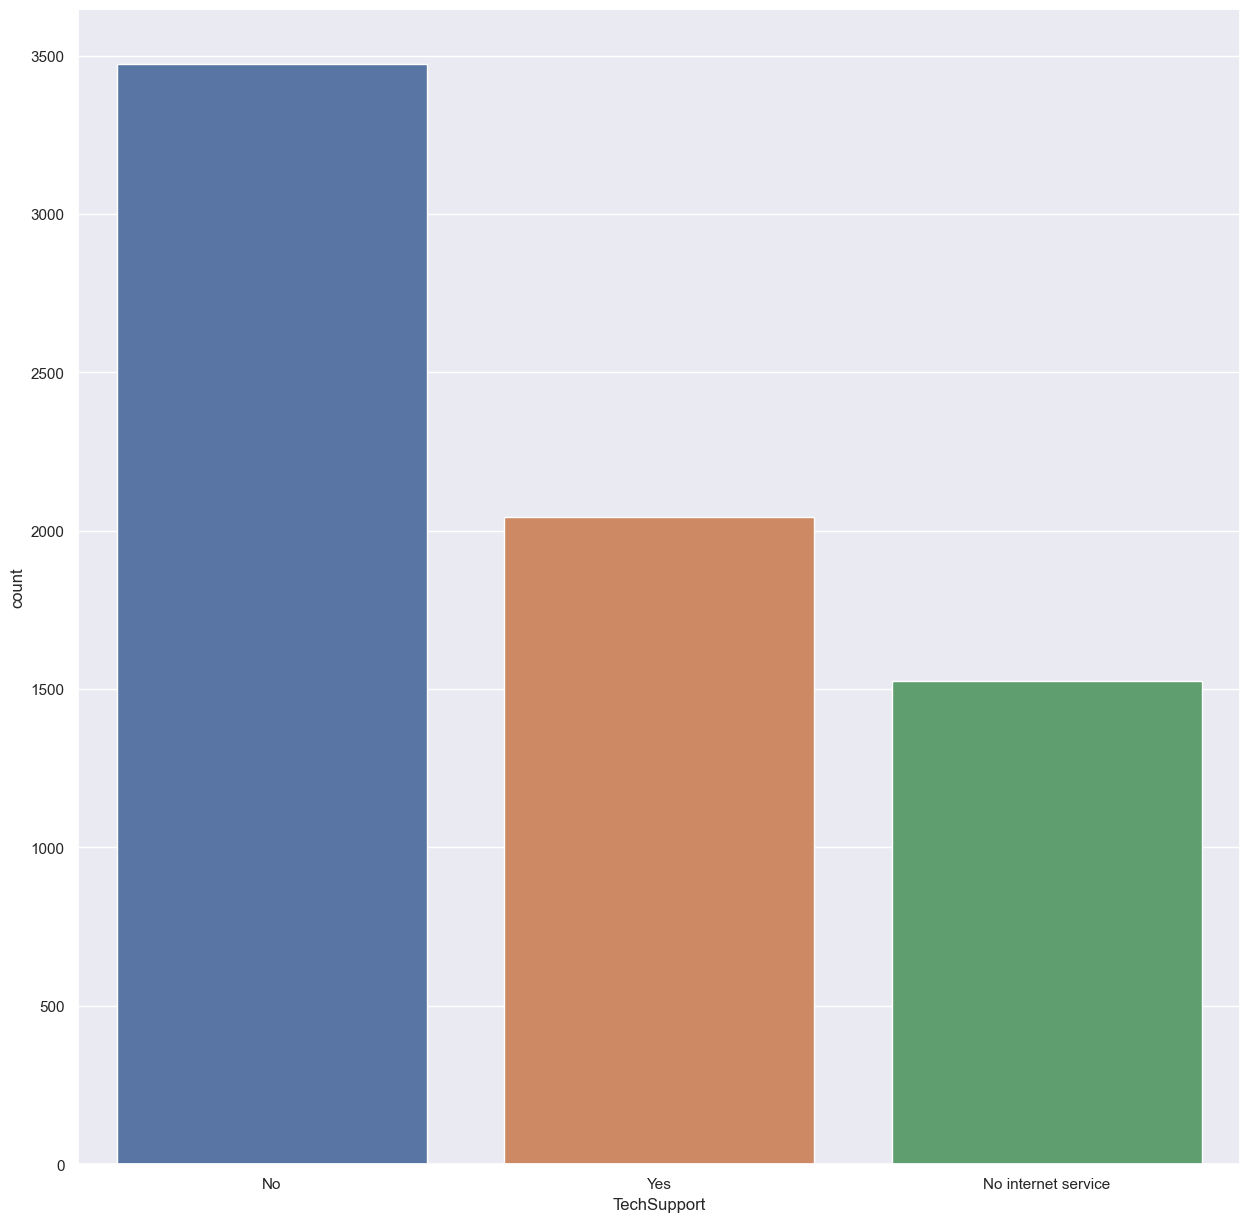

                     StreamingTV  Ratio
No                          2810  0.399
Yes                         2707  0.384
No internet service         1526  0.217


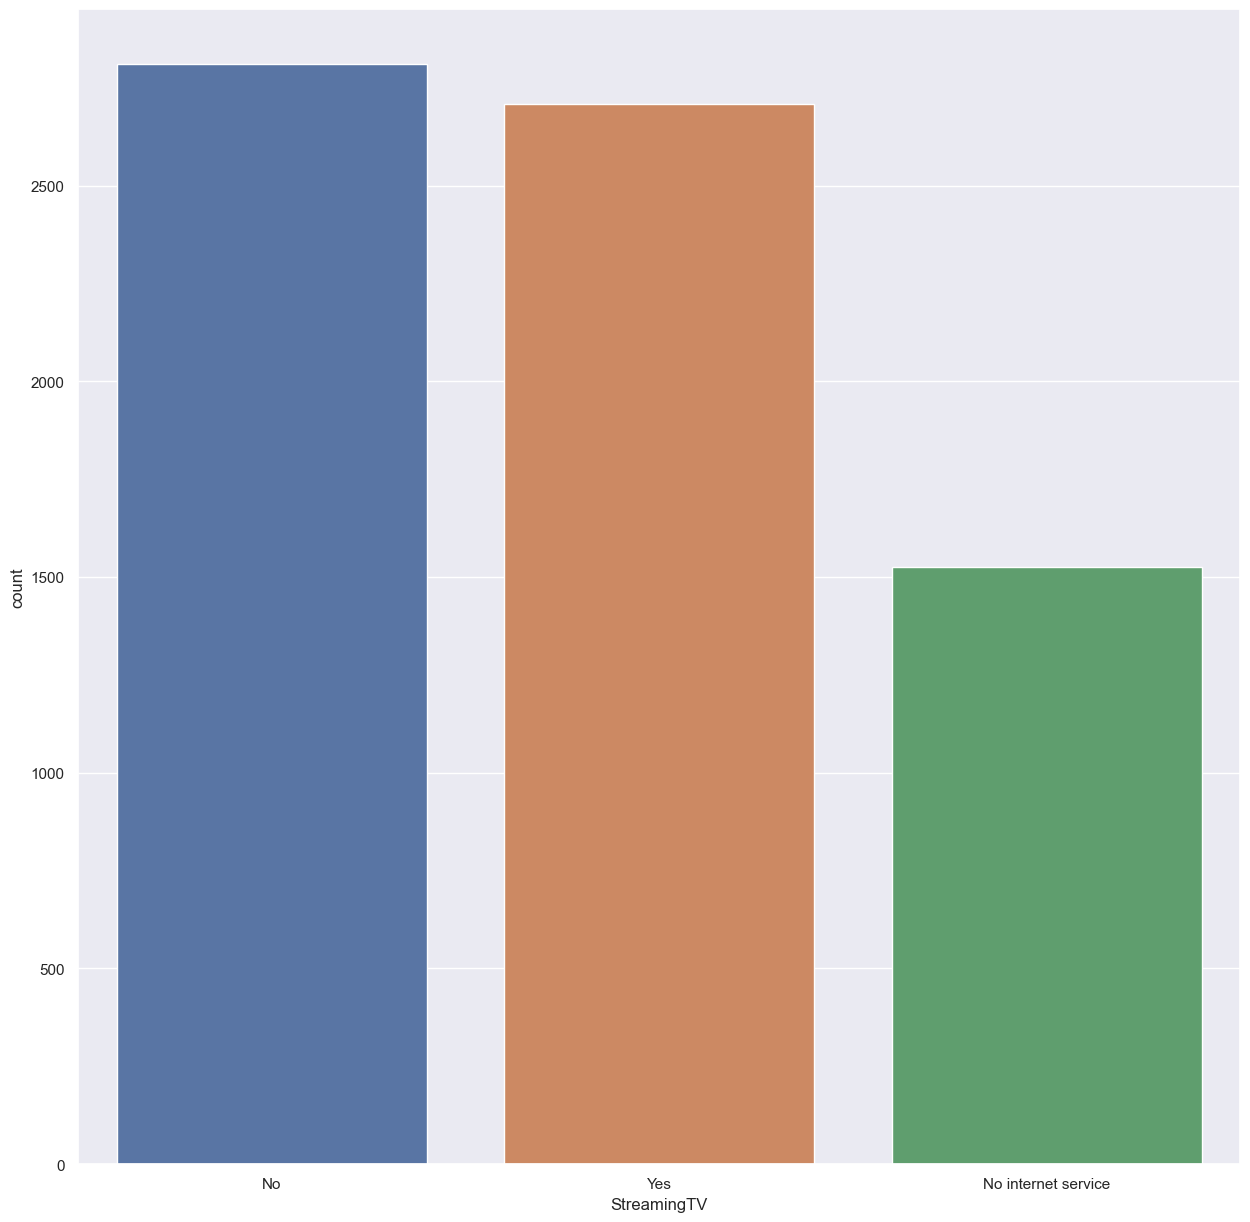

                     StreamingMovies  Ratio
No                              2785  0.395
Yes                             2732  0.388
No internet service             1526  0.217


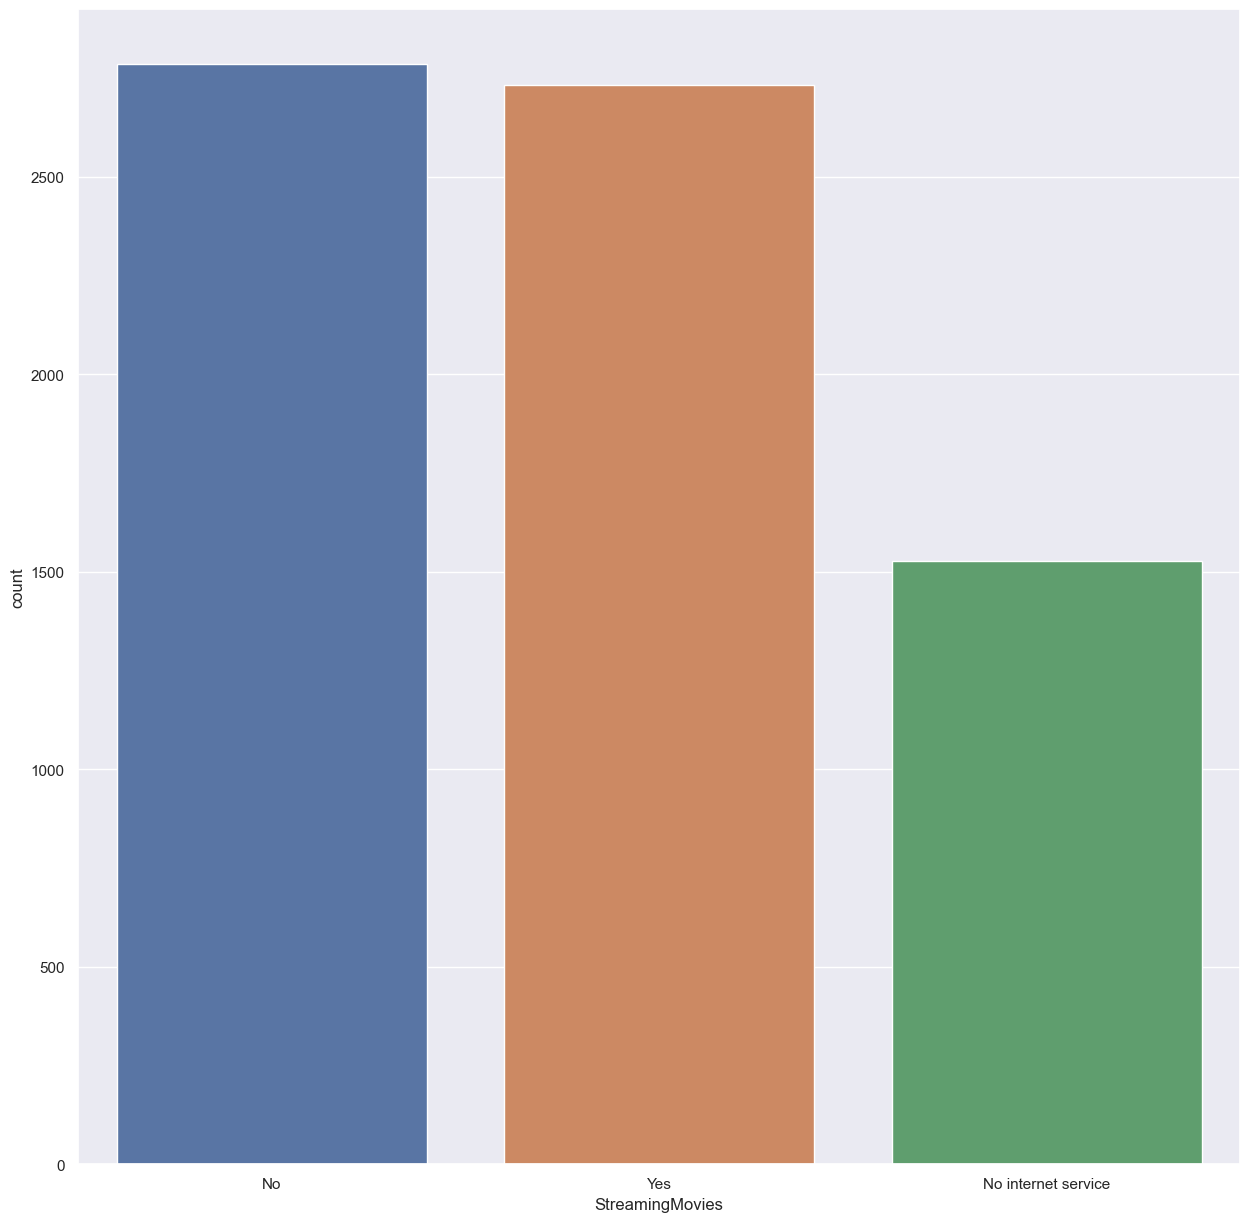

                Contract  Ratio
Month-to-month      3875  0.550
Two year            1695  0.241
One year            1473  0.209


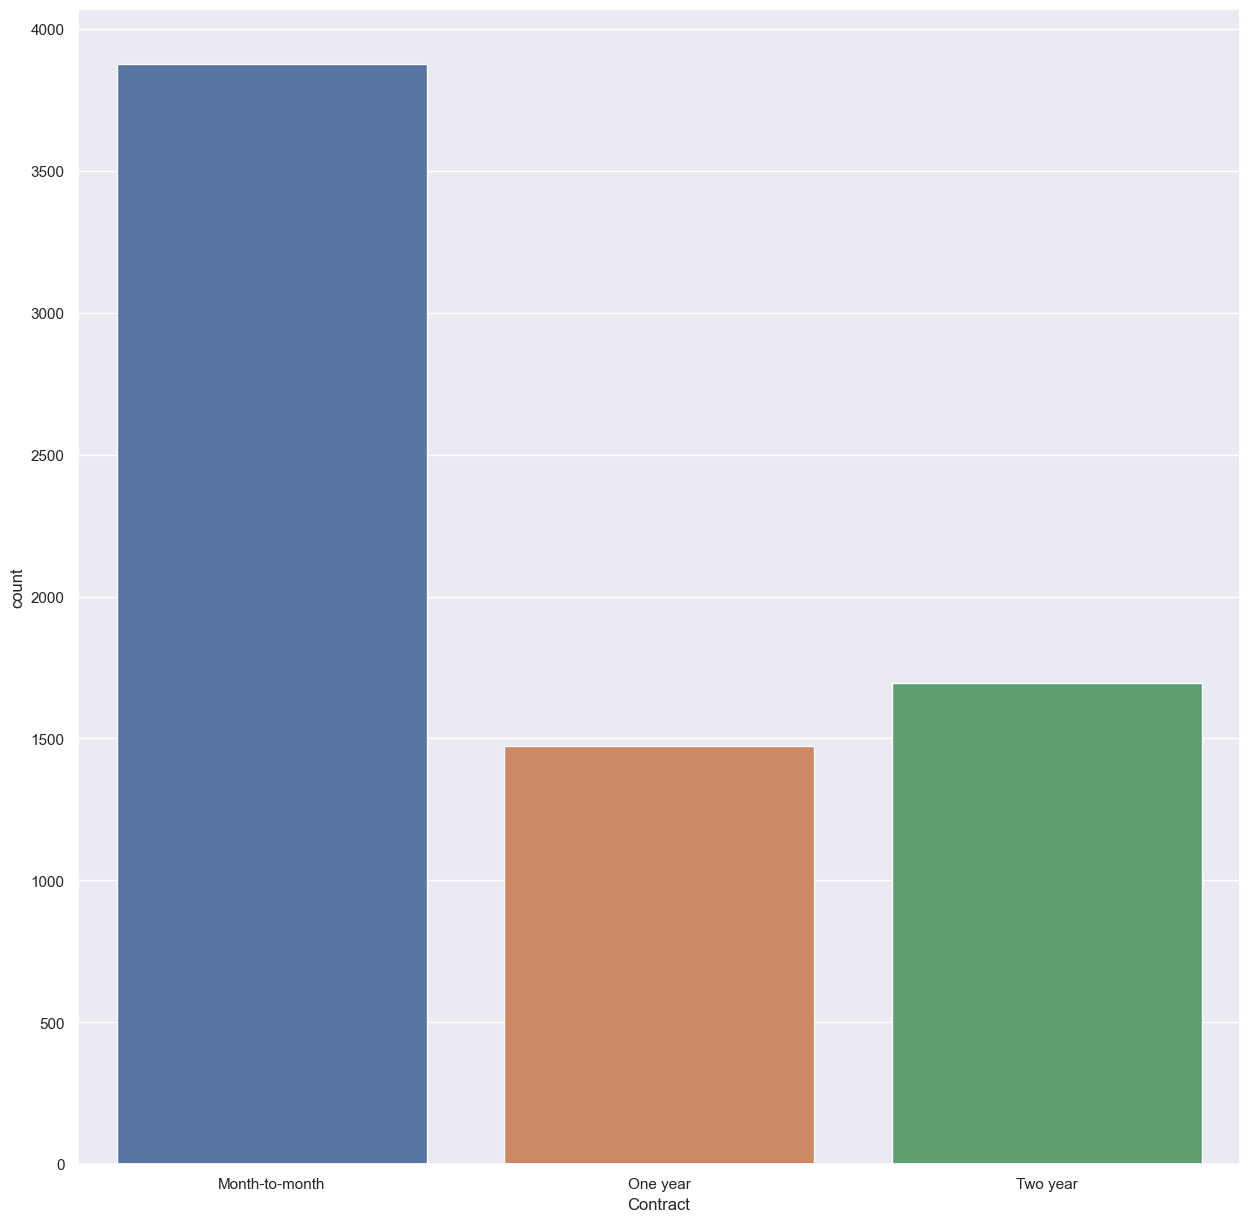

     PaperlessBilling  Ratio
Yes              4171  0.592
No               2872  0.408


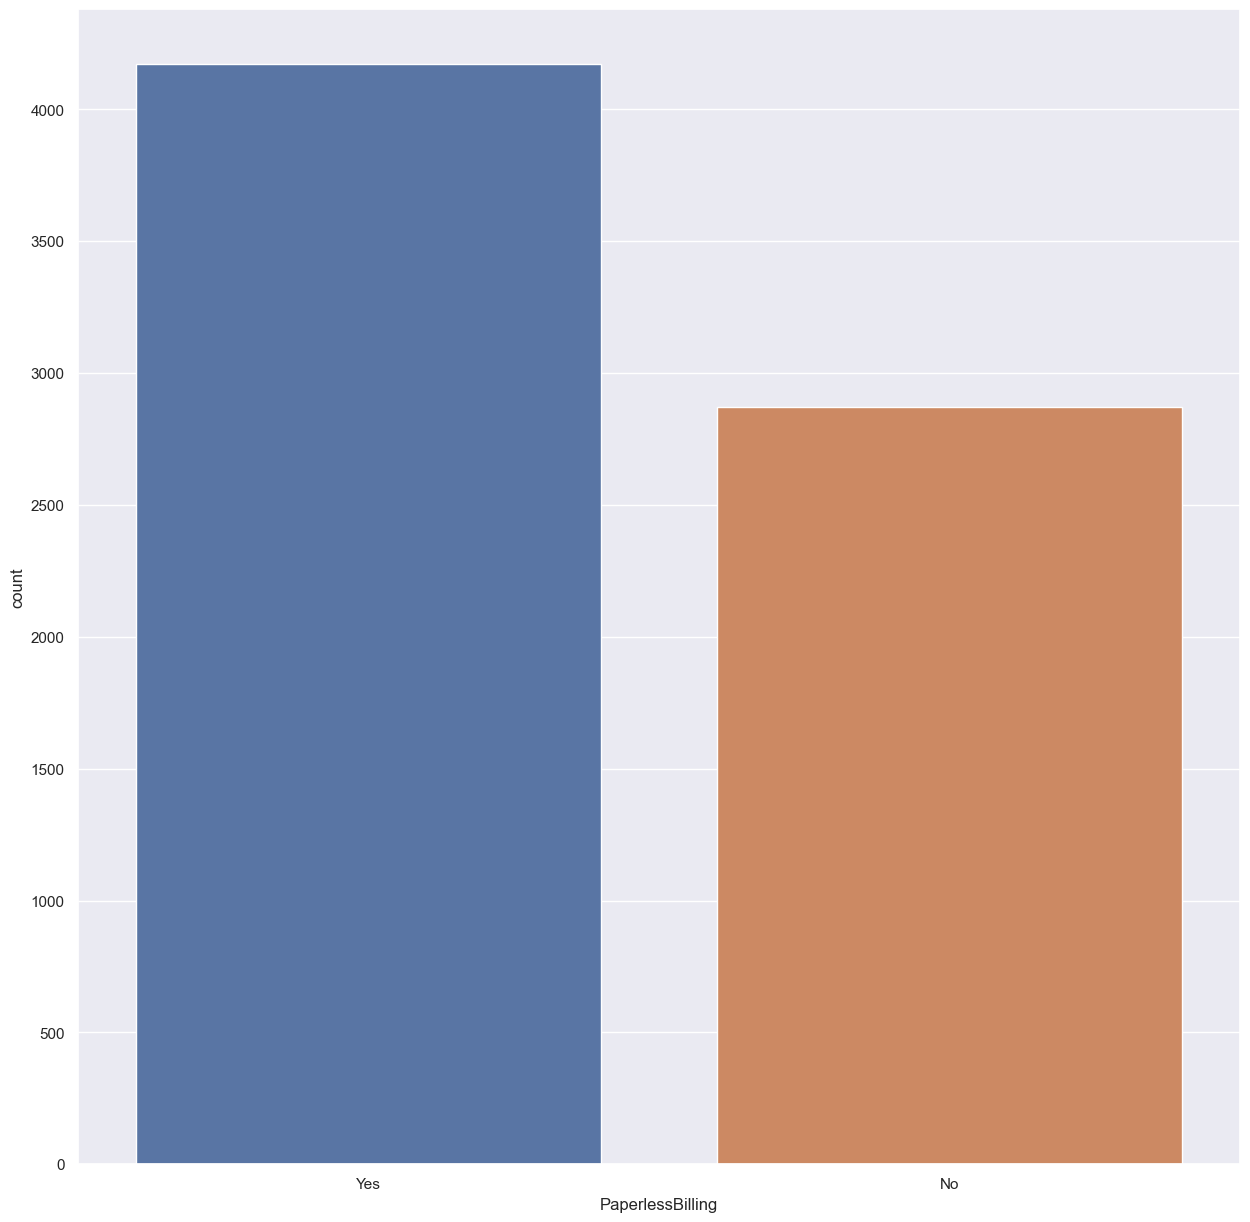

                           PaymentMethod  Ratio
Electronic check                    2365  0.336
Mailed check                        1612  0.229
Bank transfer (automatic)           1544  0.219
Credit card (automatic)             1522  0.216


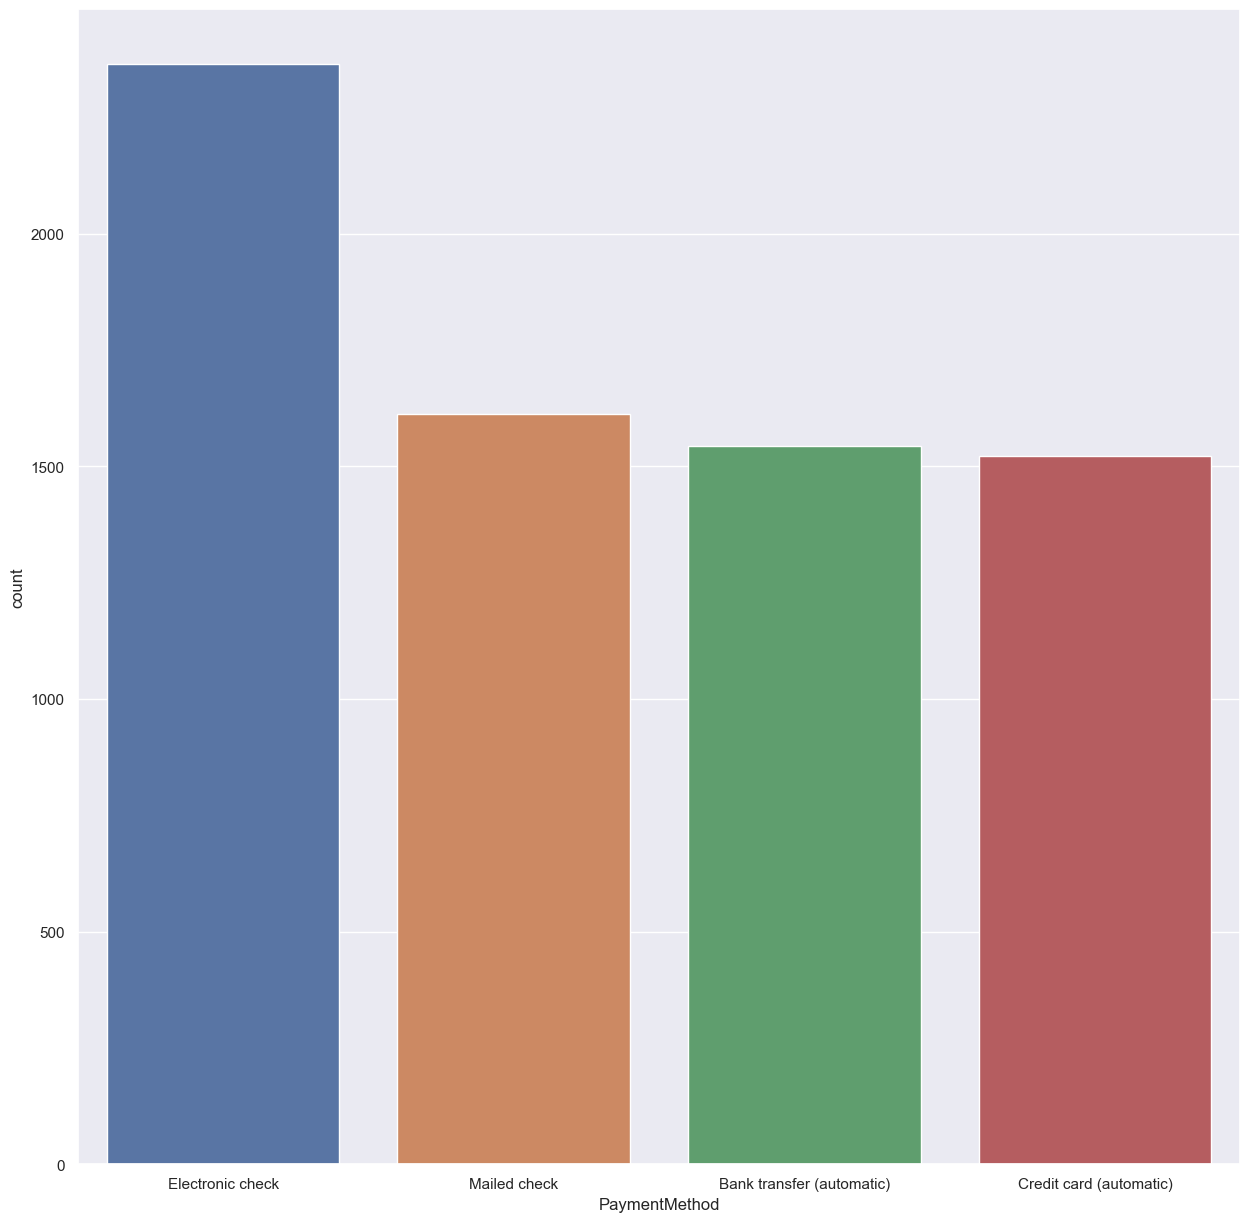

   SeniorCitizen  Ratio
0           5901  0.838
1           1142  0.162


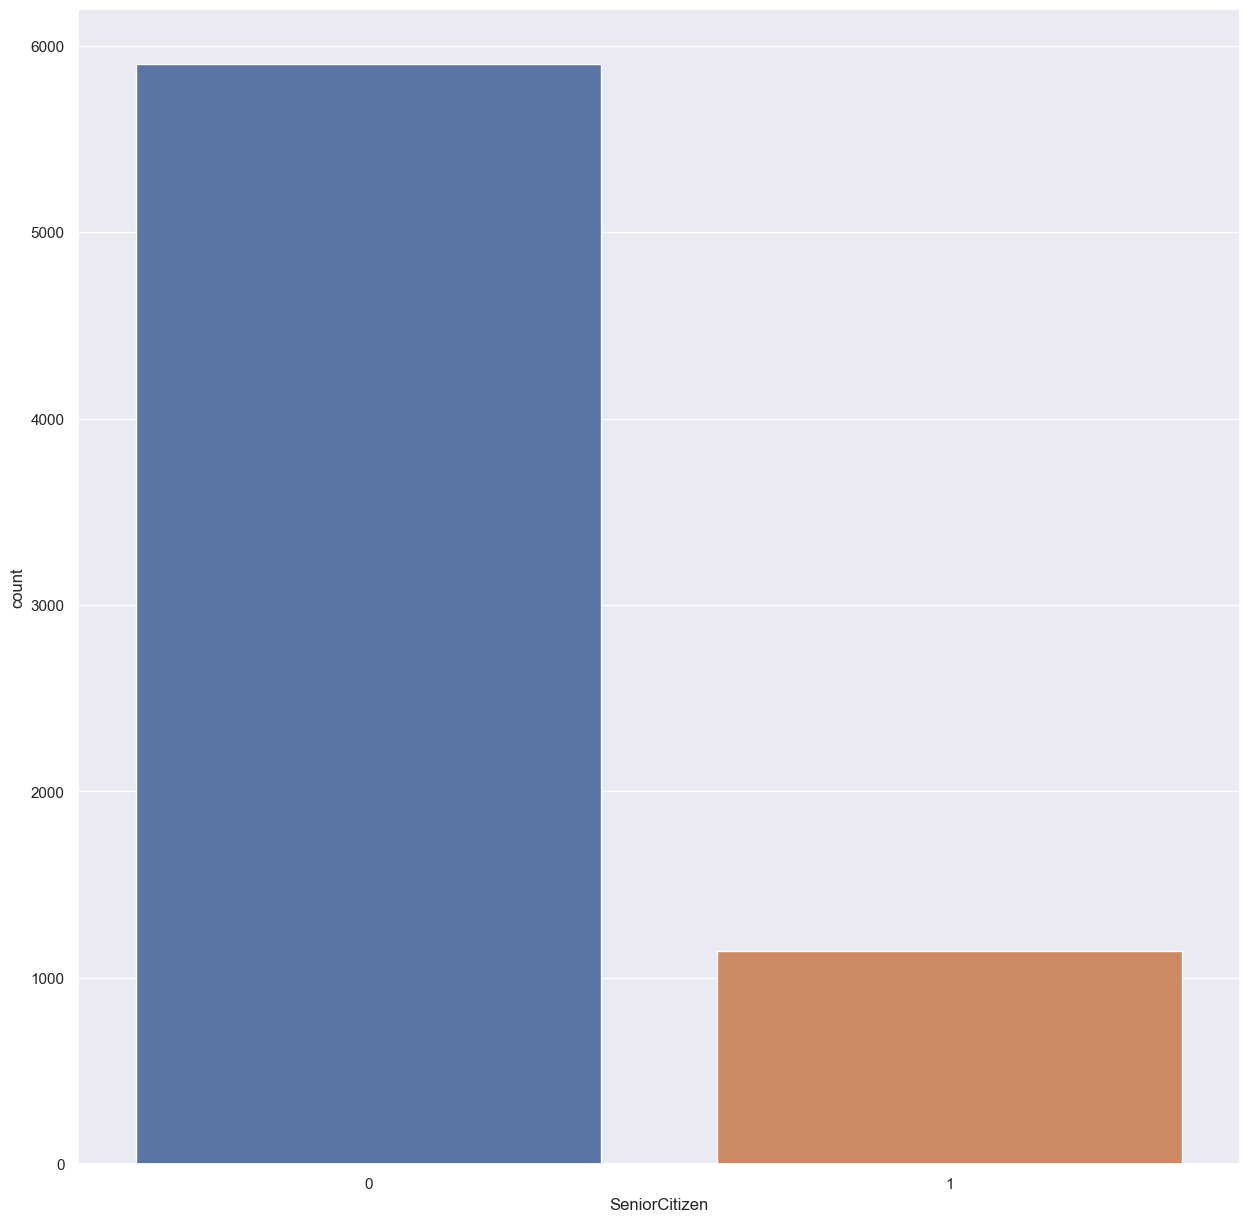

   Churn  Ratio
0   5174  0.735
1   1869  0.265


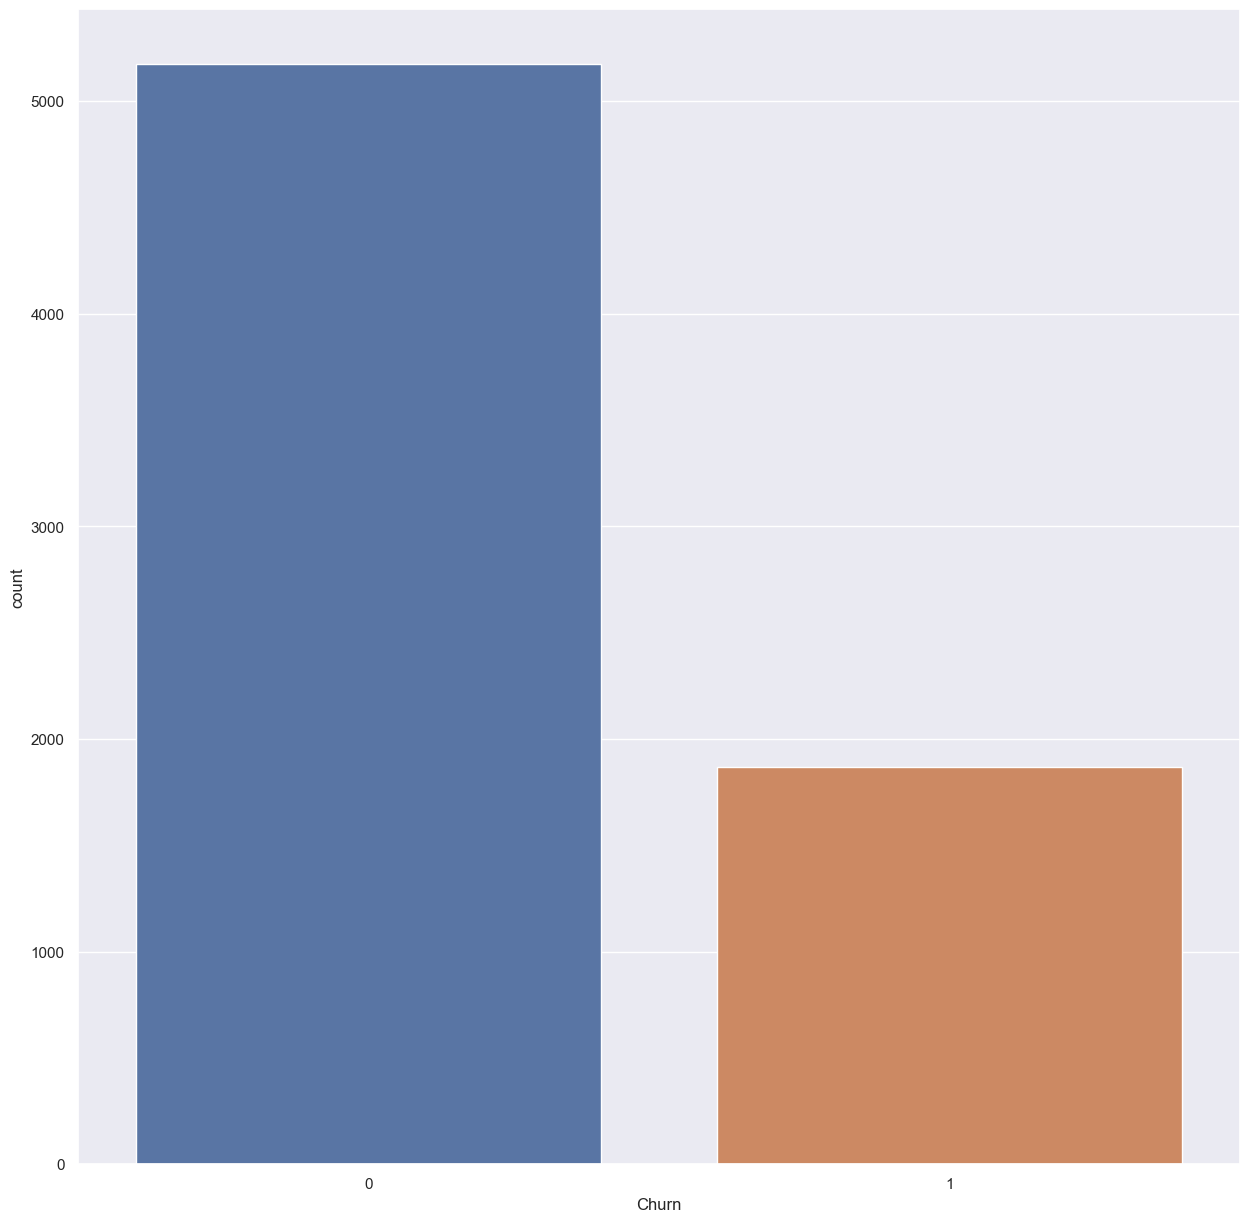

In [580]:
for col in cat_cols:
    categorical_summary(df,col,True)

In [581]:
def numerical_summary(dataframe, col_name, plot = False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)
    
    if plot:
        dataframe[col_name].hist(bins = 20)
        plt.title(col_name)
        plt.xlabel(col_name)
        plt.show()

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


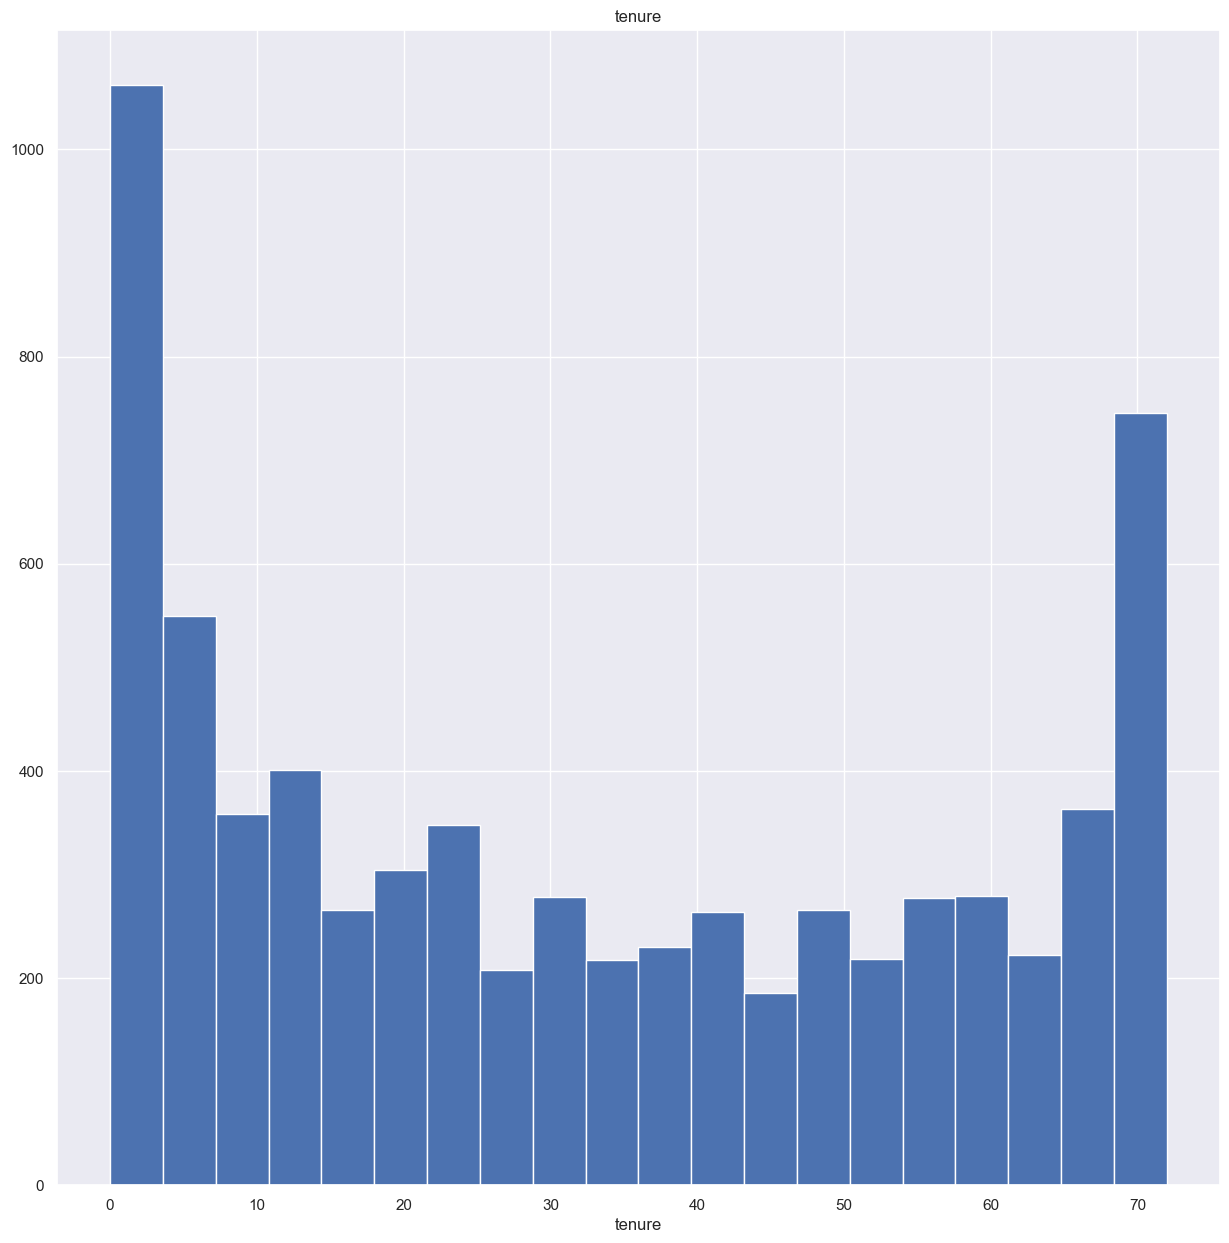

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


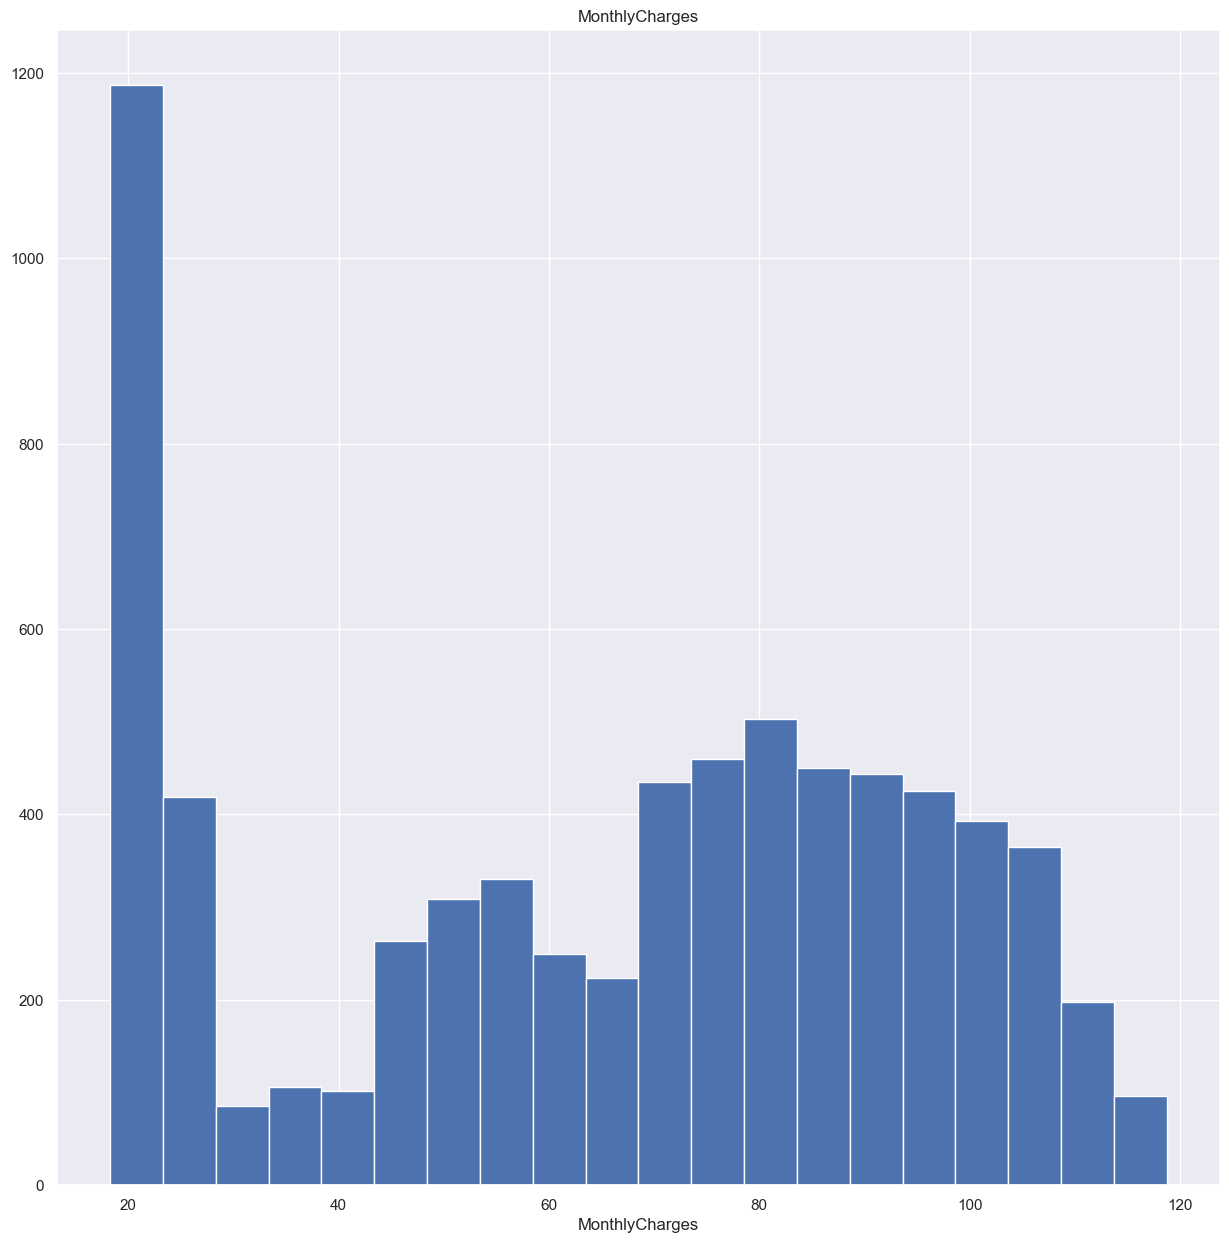

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


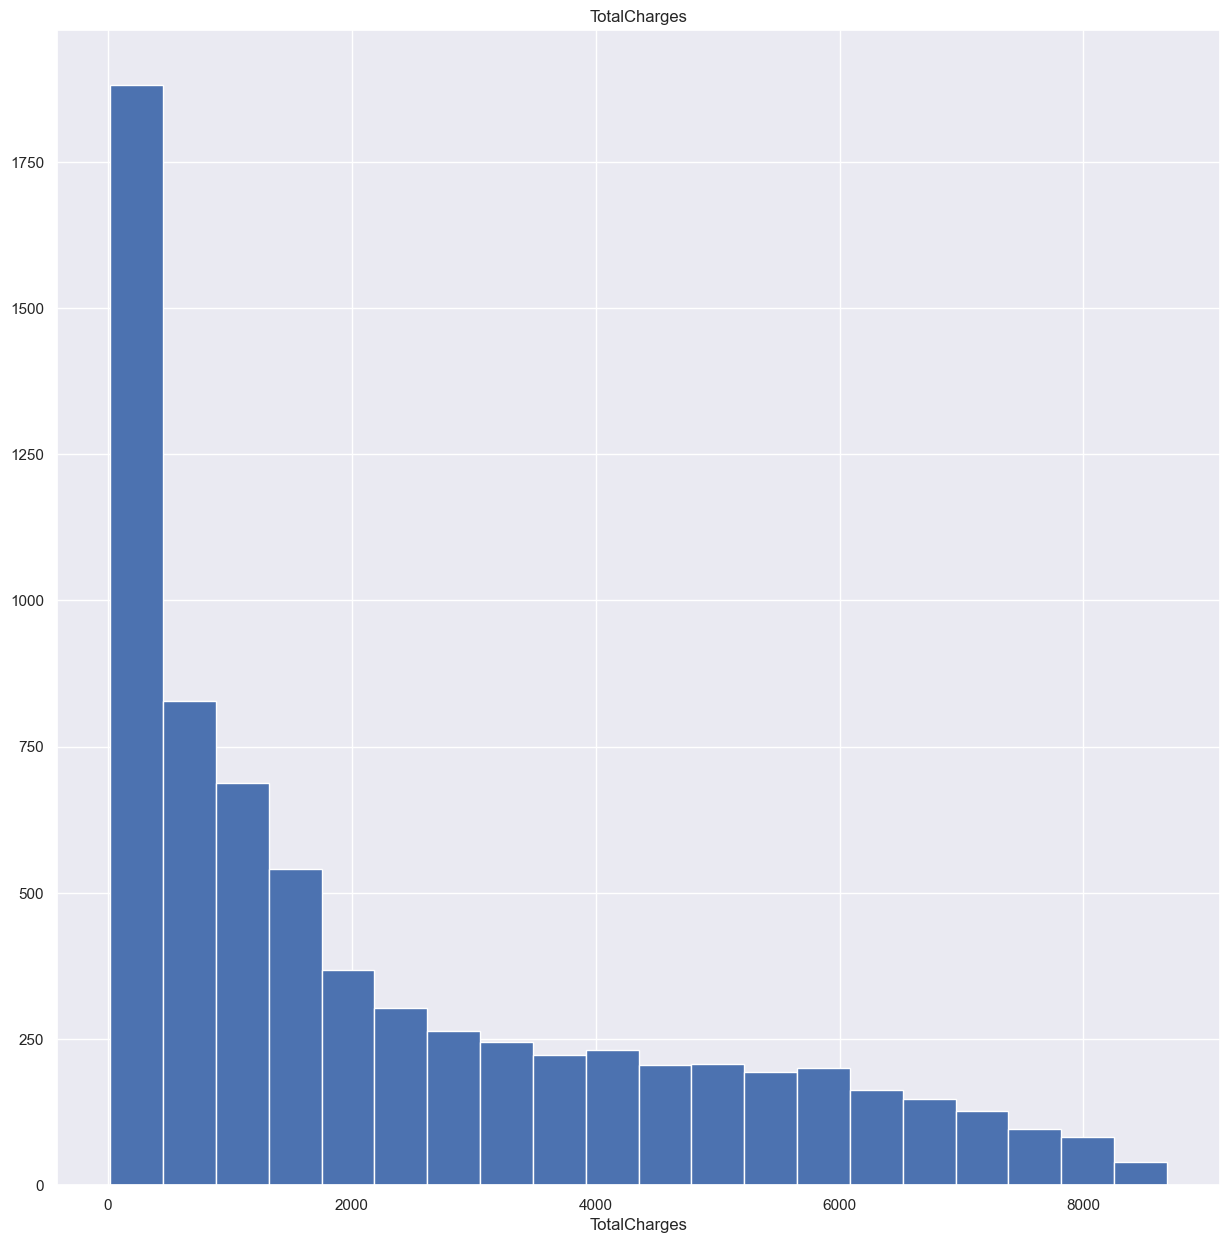

In [582]:
for col in num_cols:
    numerical_summary(df,col,True)

### Step 4: Perform the target variable analysis with categorical variables.

In [583]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


In [584]:
for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

        TARGET_MEAN
gender             
Female        0.269
Male          0.262


         TARGET_MEAN
Partner             
No             0.330
Yes            0.197


            TARGET_MEAN
Dependents             
No                0.313
Yes               0.155


              TARGET_MEAN
PhoneService             
No                  0.249
Yes                 0.267


                  TARGET_MEAN
MultipleLines                
No                      0.250
No phone service        0.249
Yes                     0.286


                 TARGET_MEAN
InternetService             
DSL                    0.190
Fiber optic            0.419
No                     0.074


                     TARGET_MEAN
OnlineSecurity                  
No                         0.418
No internet service        0.074
Yes                        0.146


                     TARGET_MEAN
OnlineBackup                    
No                         0.399
No internet service        0.074
Yes                        0.2

### Step 5: Check if there are any outliers.

In [585]:
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    
    interquartile = quartile3 - quartile1
    up = quartile3 + 1.5 * interquartile 
    low = quartile1 - 1.5 * interquartile
    return low, up

In [586]:
def check_outlier(dataframe, col_name):
    low, up = outlier_thresholds(dataframe, col_name,0.1,0.9)
    
    if dataframe[(dataframe[col_name] > up) | (dataframe[col_name] < low)].any(axis= None):
        return True
    else:
        return False

In [587]:
for col in num_cols:
    print(col, check_outlier(df,col))

tenure False
MonthlyCharges False
TotalCharges False


### Step 6: Check if there are any missing observations.

In [588]:
df.isnull().values.any()

True

In [589]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [590]:
df[df.isnull().any(axis = 1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,NaN,0


In [591]:
(df.isnull().sum()/df.shape[0]*100).sort_values(ascending = False)

TotalCharges       0.156
customerID         0.000
DeviceProtection   0.000
MonthlyCharges     0.000
PaymentMethod      0.000
PaperlessBilling   0.000
Contract           0.000
StreamingMovies    0.000
StreamingTV        0.000
TechSupport        0.000
OnlineBackup       0.000
gender             0.000
OnlineSecurity     0.000
InternetService    0.000
MultipleLines      0.000
PhoneService       0.000
tenure             0.000
Dependents         0.000
Partner            0.000
SeniorCitizen      0.000
Churn              0.000
dtype: float64

In [592]:
na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]

In [593]:
na_cols

['TotalCharges']

In [594]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    
    missing_df = pd.concat([n_miss,ratio], axis = 1, keys = ["n_miss","ratio"])
    print(missing_df, end="\n")
    
    if na_name:
        return na_columns

In [595]:
missing_values_table(df)

              n_miss  ratio
TotalCharges      11  0.156


### Step 7: Perform correlation analysis.

In [596]:
df.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000,0.017,0.220,0.102,0.151
tenure,0.017,1.000,0.248,0.826,-0.352
MonthlyCharges,0.220,0.248,1.000,0.651,0.193
TotalCharges,0.102,0.826,0.651,1.000,-0.199
Churn,0.151,-0.352,0.193,-0.199,1.000


In [597]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool_))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu", annot=True)
        plt.show(block=True)
    return drop_list

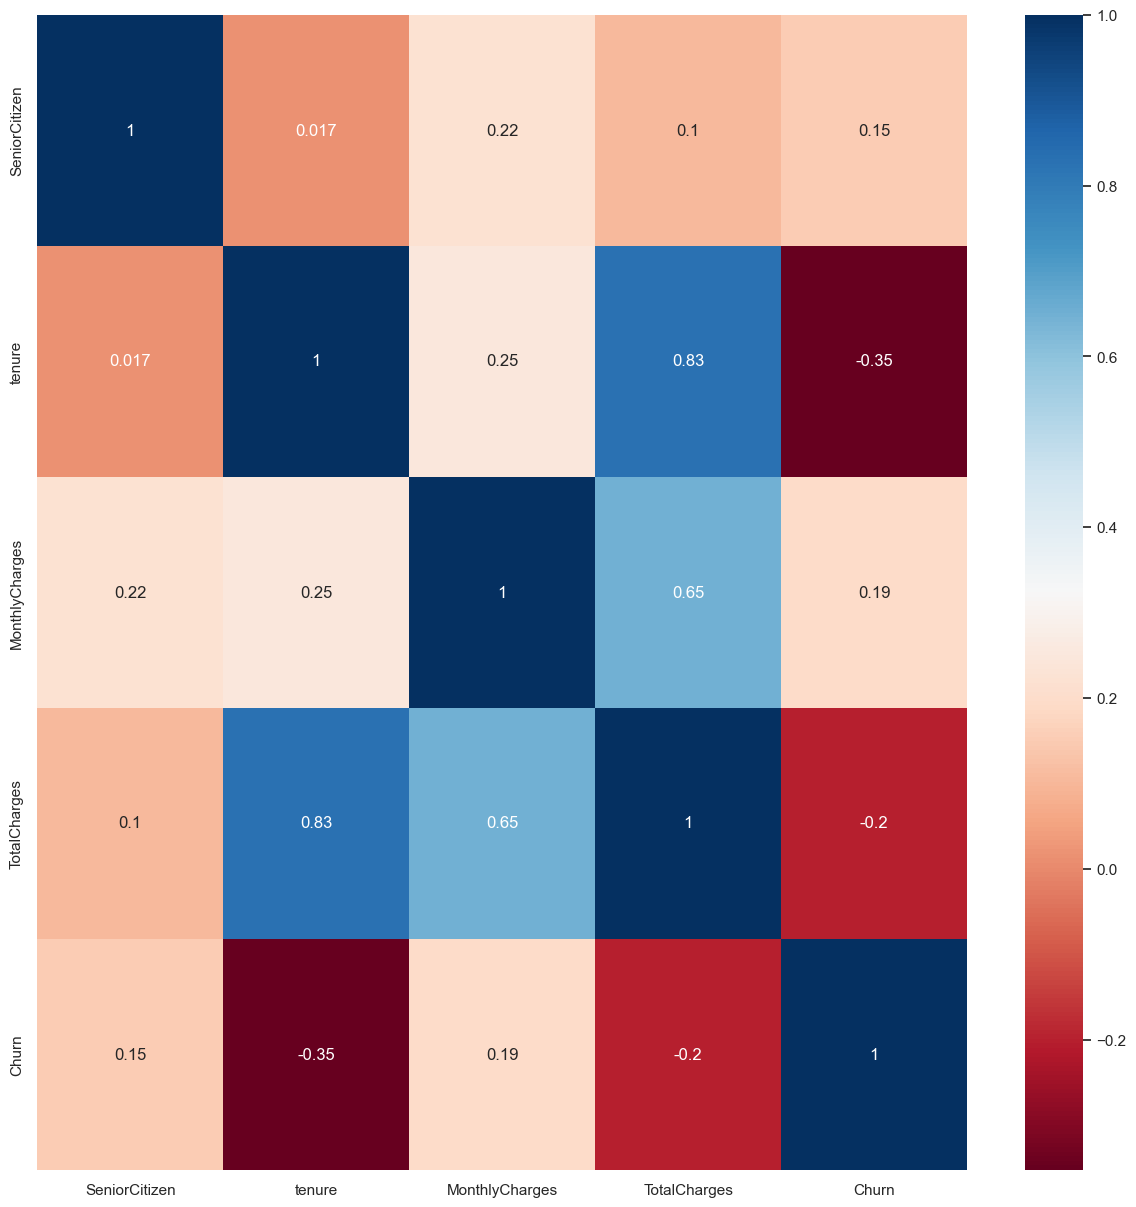

[]

In [598]:
high_correlated_cols(df, plot=True)

## Task 2: Feature Engineering

### Step 1: Take the necessary actions for missing and contradictory observations.

In [599]:
#df["TotalCharges"].fillna(0, inplace = True)

In [600]:
df[df.isnull().any(axis = 1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,NaN,0


In [601]:
df.loc[df['TotalCharges'].isnull(), 'tenure'] = 1
df.loc[df['TotalCharges'].isnull(), 'TotalCharges'] = df['MonthlyCharges']


In [604]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


## Base Model

In [605]:
dff = df.copy()

In [606]:
cat_cols = [col for col in cat_cols if col not in ["Churn"]]

In [607]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [608]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [609]:
dff = one_hot_encoder(dff, cat_cols, drop_first=True)

In [610]:
y = dff["Churn"]
X = dff.drop(["Churn","customerID"], axis=1)

In [611]:
models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('SVM', SVC(gamma='auto', random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

In [612]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

########## LR ##########
Accuracy: 0.8039
Auc: 0.8427
Recall: 0.542
Precision: 0.6586
F1: 0.5946
########## KNN ##########
Accuracy: nan
Auc: nan
Recall: nan
Precision: nan
F1: nan
########## CART ##########
Accuracy: 0.7248
Auc: 0.6503
Recall: 0.4896
Precision: 0.4817
F1: 0.4855
########## RF ##########
Accuracy: 0.7873
Auc: 0.8233
Recall: 0.4762
Precision: 0.6325
F1: 0.5432
########## SVM ##########
Accuracy: 0.7667
Auc: 0.7128
Recall: 0.2809
Precision: 0.6386
F1: 0.3898
########## XGB ##########
Accuracy: 0.7845
Auc: 0.8231
Recall: 0.5072
Precision: 0.615
F1: 0.5557
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [I

### Step 2: Create new variables.

In [613]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.000,0.162,0.369,0.000,0.000,0.000,0.000,1.000
tenure,7043.000,32.373,24.557,1.000,9.000,29.000,55.000,72.000
MonthlyCharges,7043.000,64.762,30.090,18.250,35.500,70.350,89.850,118.750
TotalCharges,7043.000,2279.799,2266.730,18.800,398.550,1394.550,3786.600,8684.800
Churn,7043.000,0.265,0.442,0.000,0.000,0.000,1.000,1.000


In [614]:
df.columns = [col.upper() for col in df.columns]

In [615]:
# Creating annual categorical variable from Tenure variable
df["NEW_TENURE"] = pd.cut(x = df["TENURE"], bins = [0, 12, 24, 36, 48, 60, 72],
                          labels = ["0-1 Year","1-2 Year","2-3 Year","3-4 Year","4-5 Year","5-6 Year"])

In [616]:
#senior and no partner
df["NEW_DEPENDENTS_SENIORCITIZEN"] = df.apply(lambda x : 1 if ( x["DEPENDENTS"] == "No") and(x["SENIORCITIZEN"] ==1) else 0, axis = 1)

In [617]:
# People who do not receive any support, backup or protection
df["NEW_ISOLATED_INDIVIDUALS"] = df.apply(lambda x : 1 if ( x["TECHSUPPORT"] == "No") and ( x["DEVICEPROTECTION"] == "No") and
                                          ( x["ONLINEBACKUP"] == "No") and( x["ONLINESECURITY"] == "No")  else 0, axis = 1)

In [618]:
df["NEW_PAYMENT_AND_BILLING"] = df.apply(lambda x : 1 if ( x["PAPERLESSBILLING"] == "Yes") and(x["PAYMENTMETHOD"] =="Electronic check") else 0, axis = 1)

In [619]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN,NEW_TENURE,NEW_DEPENDENTS_SENIORCITIZEN,NEW_ISOLATED_INDIVIDUALS,NEW_PAYMENT_AND_BILLING
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,0,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,0,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1


In [620]:
# Specify 1 or 2 year contract customers as Engaged
df["NEW_ENGAGED"] = df["CONTRACT"].apply(lambda x : 1 if x in["One year", "Two year"] else 0)

In [621]:
# Hiking with monthly contract and not young
df["NEW_YOUNG_NOT_ENGAGED"] = df.apply(lambda x : 1 if (x["NEW_ENGAGED"] == 0) and (x["SENIORCITIZEN"] == 0) else 0, axis = 1)

In [622]:
df['NEW_TOTALSERVICES'] = (
    (df[["STREAMINGMOVIES", "STREAMINGTV", "TECHSUPPORT",
      "DEVICEPROTECTION", "ONLINEBACKUP", "ONLINESECURITY", "PHONESERVICE"]] == "Yes").sum(axis=1) +
    ((df[["INTERNETSERVICE"]] == "DSL") | (df[["INTERNETSERVICE"]] == "Fiber Optic")).sum(axis=1)
)

In [623]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN,NEW_TENURE,NEW_DEPENDENTS_SENIORCITIZEN,NEW_ISOLATED_INDIVIDUALS,NEW_PAYMENT_AND_BILLING,NEW_ENGAGED,NEW_YOUNG_NOT_ENGAGED,NEW_TOTALSERVICES
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,0,1,0,1,2
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,0,0,0,1,0,4
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,0,0,0,1,4
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,0,0,0,1,0,4
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,0,1,1


In [624]:
# People who buy any streaming service
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x : 1 if (x["STREAMINGTV"] == "Yes") or(x["STREAMINGMOVIES"] == "Yes")  else 0 , axis = 1)

In [625]:
# Does the person make automatic payments?
df["NEW_FLAG_AUTO_PAYMENT"] = df["PAYMENTMETHOD"].apply(lambda x : 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [626]:
#paperless and electronic payment
df["NEW_PAPERLESS_AND_ELECTRONIC_CHECK"] = df.apply(lambda x : 1 if (x["PAYMENTMETHOD"] == "Electronic check") and (x["PAPERLESSBILLING"] == "Yes") else 0, axis = 1)

In [627]:
# average monthly payment
df["NEW_AVG_CHARGES"] = df["TOTALCHARGES"] / (df["TENURE"] + 1)

In [628]:
#  Current Price increase relative to average price
df["NEW_INCREASE_CHARGES"] = df["NEW_AVG_CHARGES"] /df["MONTHLYCHARGES"]

In [629]:
# Charge per service
df["NEW_AVG_SERVICE_FEE"] = df["MONTHLYCHARGES"] / (df["NEW_TOTALSERVICES"]+1)

In [630]:
#payout rate for all customers
df["NEW_AVG_ALL_CHARGES"] = df["NEW_AVG_CHARGES"].mean() / (df["NEW_AVG_CHARGES"] + 1)

### Step 3: Perform the encoding operations.

#### Label Encoding

In [631]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [632]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
              and df[col].nunique() == 2]

In [633]:
binary_cols

['GENDER',
 'SENIORCITIZEN',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'PAPERLESSBILLING',
 'CHURN',
 'NEW_DEPENDENTS_SENIORCITIZEN',
 'NEW_ISOLATED_INDIVIDUALS',
 'NEW_PAYMENT_AND_BILLING',
 'NEW_ENGAGED',
 'NEW_YOUNG_NOT_ENGAGED',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AUTO_PAYMENT',
 'NEW_PAPERLESS_AND_ELECTRONIC_CHECK']

In [634]:
for col in binary_cols:
    label_encoder(df, col)

#### One Hot Encoding

In [635]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 35
Categorical Columns: 27
Numeric Columns: 7
Categorical Looking but Cardinal: 1
Numeric Looking but Categorical: 17


In [636]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [637]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["CHURN","NEW_TOTALSERVICES"]]

In [638]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [639]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,CHURN,NEW_DEPENDENTS_SENIORCITIZEN,NEW_ISOLATED_INDIVIDUALS,NEW_PAYMENT_AND_BILLING,NEW_ENGAGED,NEW_YOUNG_NOT_ENGAGED,NEW_TOTALSERVICES,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AUTO_PAYMENT,NEW_PAPERLESS_AND_ELECTRONIC_CHECK,NEW_AVG_CHARGES,NEW_INCREASE_CHARGES,NEW_AVG_SERVICE_FEE,NEW_AVG_ALL_CHARGES,MULTIPLELINES_No phone service,MULTIPLELINES_Yes,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,ONLINESECURITY_No internet service,ONLINESECURITY_Yes,ONLINEBACKUP_No internet service,ONLINEBACKUP_Yes,DEVICEPROTECTION_No internet service,DEVICEPROTECTION_Yes,TECHSUPPORT_No internet service,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check,NEW_TENURE_1-2 Year,NEW_TENURE_2-3 Year,NEW_TENURE_3-4 Year,NEW_TENURE_4-5 Year,NEW_TENURE_5-6 Year
0,7590-VHVEG,0,0,1,0,1,0,1,29.850,29.850,0,0,0,1,0,1,2,0,0,1,14.925,0.500,9.950,3.706,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.950,1889.500,0,0,0,0,1,0,4,0,0,0,53.986,0.948,11.390,1.073,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
2,3668-QPYBK,1,0,0,0,2,1,1,53.850,108.150,1,0,0,0,0,1,4,0,0,0,36.050,0.669,10.770,1.593,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,7795-CFOCW,1,0,0,0,45,0,0,42.300,1840.750,0,0,0,0,1,0,4,0,1,0,40.016,0.946,8.460,1.439,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,9237-HQITU,0,0,0,0,2,1,1,70.700,151.650,1,0,1,1,0,1,1,0,0,1,50.550,0.715,35.350,1.145,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### Step 4: Standardize for numeric variables.

In [640]:
num_cols

['TENURE',
 'MONTHLYCHARGES',
 'TOTALCHARGES',
 'NEW_AVG_CHARGES',
 'NEW_INCREASE_CHARGES',
 'NEW_AVG_SERVICE_FEE',
 'NEW_AVG_ALL_CHARGES']

In [641]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [642]:
df[num_cols].head()

,TENURE,MONTHLYCHARGES,TOTALCHARGES,NEW_AVG_CHARGES,NEW_INCREASE_CHARGES,NEW_AVG_SERVICE_FEE,NEW_AVG_ALL_CHARGES
0,-1.278,-1.160,-0.993,-1.444,-2.647,-0.827,2.033
1,0.066,-0.260,-0.172,-0.165,0.331,-0.627,-0.355
2,-1.237,-0.363,-0.958,-0.752,-1.520,-0.713,0.116
3,0.514,-0.747,-0.194,-0.623,0.318,-1.033,-0.023
4,-1.237,0.197,-0.939,-0.278,-1.217,2.689,-0.290


## Task 3: Modeling

### Step 1: Building models with classification algorithms and examining accuracy scores. Select the 4 best models.

In [643]:
y = df["CHURN"]
X = df.drop(["CHURN", "CUSTOMERID"], axis = 1) 

In [644]:
models = [("LR", LogisticRegression(random_state=12345)),
         ("KNN", KNeighborsClassifier()),
         ("CART", DecisionTreeClassifier(random_state=12345)),
         ("RF", RandomForestClassifier(random_state = 12345)),
         ("SVM", SVC(gamma = "auto", random_state = 12345)),
         ("XGB", XGBClassifier(random_state = 12345)),
         ("LightGBM", LGBMClassifier(random_state=12345)),
         ("CatBoost", CatBoostClassifier(verbose = False, random_state = 12345))]

In [645]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv = 3,  scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")
    

########## LR ##########
Accuracy: 0.8065
Auc: 0.8489
Recall: 0.534
Precision: 0.6699
F1: 0.5942
########## KNN ##########
Accuracy: nan
Auc: nan
Recall: nan
Precision: nan
F1: nan
########## CART ##########
Accuracy: 0.7267
Auc: 0.6481
Recall: 0.4815
Precision: 0.4847
F1: 0.4831
########## RF ##########
Accuracy: 0.7934
Auc: 0.826
Recall: 0.496
Precision: 0.6441
F1: 0.5604
########## SVM ##########
Accuracy: 0.8001
Auc: 0.8128
Recall: 0.4682
Precision: 0.679
F1: 0.5542
########## XGB ##########
Accuracy: 0.789
Auc: 0.8224
Recall: 0.5152
Precision: 0.6242
F1: 0.5645
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1246, number of negative: 3449
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1692
[LightGBM] [Inf

### Step 2: Perform hyperparameter optimization with the models you selected and re-build the model with the hyperparameters you found.

#### XGBoost

In [647]:
xgboost_model = XGBClassifier(random_state = 17)

In [648]:
cv_results = cross_validate(xgboost_model, X, y, cv = 5,scoring=["accuracy", "f1", "roc_auc"] )

In [649]:
cv_results['test_accuracy'].mean()

0.7900054035744242

In [650]:
cv_results['test_f1'].mean()

0.5672827973866001

In [651]:
cv_results['test_roc_auc'].mean()

0.8251060052868272

In [652]:
xgboost_params = {"learning_rate":[0.1, 0.01],
                  "max_depth" : [5,8],
                  "n_estimators": [100,500,1000],
                  "colsample_bytree": [0.7,1]}

In [653]:
xgboost_best_grid = GridSearchCV(xgboost_model,xgboost_params,
                                cv = 5, n_jobs= -1, verbose=True).fit(X,y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [654]:
xgboost_best_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 1000}

In [655]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)


In [656]:
cv_results = cross_validate(xgboost_final, X, y, cv = 5, scoring=["accuracy", "f1", "roc_auc"])

In [657]:
cv_results['test_accuracy'].mean()

0.803352030776179

In [658]:
cv_results['test_f1'].mean()

0.5883207670422517

In [659]:
cv_results['test_roc_auc'].mean()

0.844032771402745

### LightGBM

In [660]:
lgbm_model = LGBMClassifier(random_state = 17)

In [661]:
cv_results = cross_validate(lgbm_model, X, y, cv = 5, scoring = ["accuracy", "f1", "roc_auc"])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1692
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

In [662]:
cv_results['test_accuracy'].mean()

0.7914256564939673

In [663]:
cv_results['test_f1'].mean()

0.570048169057484

In [664]:
cv_results['test_roc_auc'].mean()

0.8363114761147512

In [665]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

In [666]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv = 5, n_jobs = -1, verbose = True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1692
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265370 -> initscore=-1.018243
[LightGBM] [Info] Start training from score -1.018243


In [667]:
lgbm_best_grid.best_params_

{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'n_estimators': 500}

In [668]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1692
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265370 -> initscore=-1.018243
[LightGBM] [Info] Start training from score -1.018243


In [669]:
cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1692
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1692
[LightGBM] [In

In [670]:
cv_results['test_accuracy'].mean()

0.8030675366152655

In [671]:
cv_results['test_f1'].mean()

0.5865776178356711

In [672]:
cv_results['test_roc_auc'].mean()

0.8450427519515902

#### CatBoost

In [673]:
catboost_model = CatBoostClassifier(random_state = 17, verbose = False)

In [674]:
cv_results = cross_validate(catboost_model, X, y, cv = 5,
                           scoring = ["accuracy", "f1", "roc_auc"])

In [675]:
cv_results['test_accuracy'].mean()

0.7980992725337119

In [676]:
cv_results['test_f1'].mean()

0.5769327995127866

In [677]:
cv_results['test_roc_auc'].mean()

0.8401946144614932

In [678]:
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

In [679]:
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv = 5, n_jobs = -1, verbose = True).fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [680]:
catboost_best_grid.best_params_

{'depth': 6, 'iterations': 500, 'learning_rate': 0.01}

In [681]:
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state = 17).fit(X,y)

In [682]:
cv_results['test_accuracy'].mean()

0.7980992725337119

In [683]:
cv_results['test_f1'].mean()

0.5769327995127866

In [684]:
cv_results['test_roc_auc'].mean()

0.8401946144614932

#### Logistic Regression

In [685]:
log_model = LogisticRegression().fit(X, y)

In [687]:
cv_results = cross_validate(log_model, X, y,
                           cv =5,
                           scoring=["accuracy",  "f1", "roc_auc"])

In [688]:
cv_results["test_accuracy"].mean()

0.8081799632234338

In [689]:
cv_results['test_f1'].mean()

0.5988900306984226

In [690]:
cv_results['test_roc_auc'].mean()

0.8498639960425086

In [693]:
log_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [694]:
?log_model

Type:        LogisticRegression
String form: LogisticRegression()
File:        c:\users\siyar\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py
Docstring:  
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containing 64-bit
floats for optimal performance; any other input format will be converted
(and copied).

The 'newton-cg', 'sag', and 'lbfgs' solvers support only

In [696]:
log_params = {"penalty" : ['l1', 'l2', 'elasticnet', None],
               "dual": [True, False],
               "C": [0.5, 0.7, 1, 1.5 , 2, 3, 5],
		"max_iter" : [50, 100, 150, 200]}

In [697]:
log_best_grid = GridSearchCV(log_model, log_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)


Fitting 5 folds for each of 224 candidates, totalling 1120 fits


In [698]:
log_best_grid.best_params_

{'C': 0.7, 'dual': False, 'max_iter': 100, 'penalty': 'l2'}

In [699]:
log_final = log_model.set_params(**log_best_grid.best_params_, random_state = 17).fit(X, y)

In [700]:
cv_results = cross_validate(log_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])


In [701]:
cv_results['test_accuracy'].mean()

0.8083220086779791

In [702]:
cv_results['test_f1'].mean()

0.5988099826956066

In [703]:
cv_results['test_roc_auc'].mean()

0.8498686628667276

### Feature Importance

In [704]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

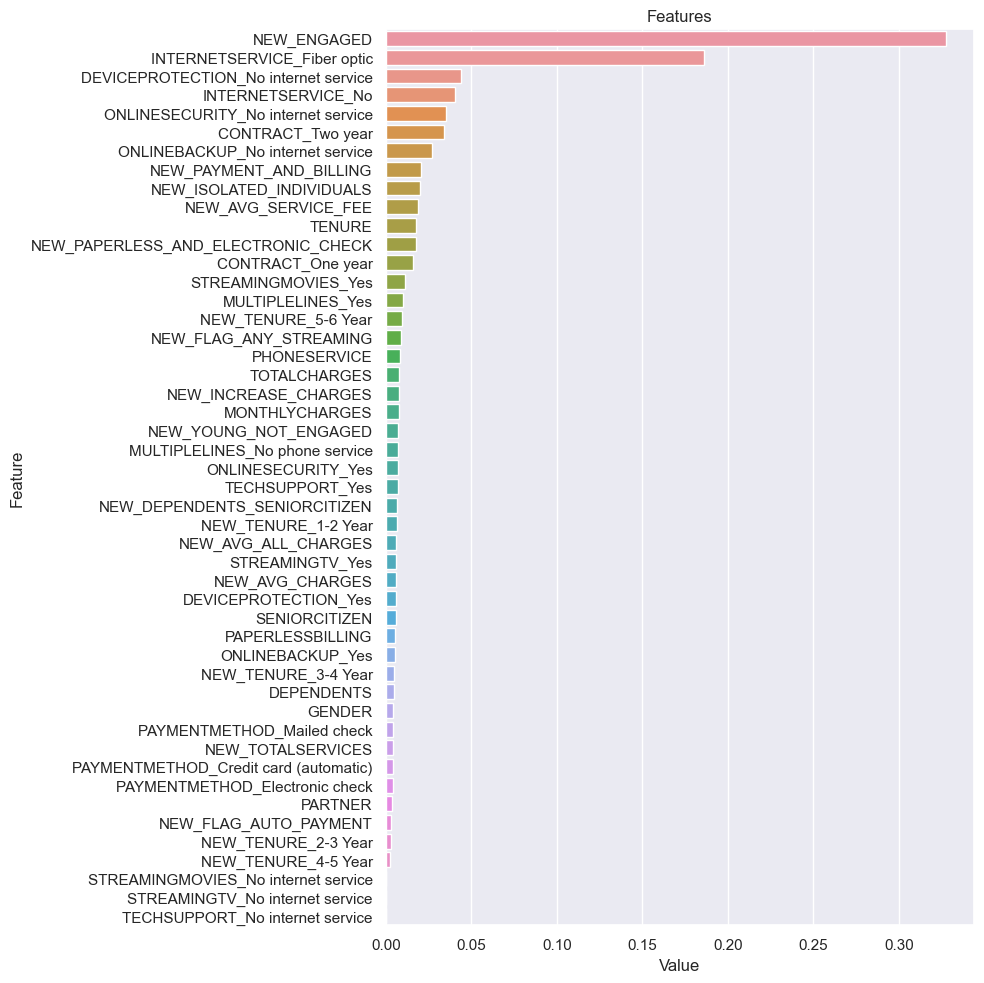

In [705]:
plot_importance(xgboost_final, X)

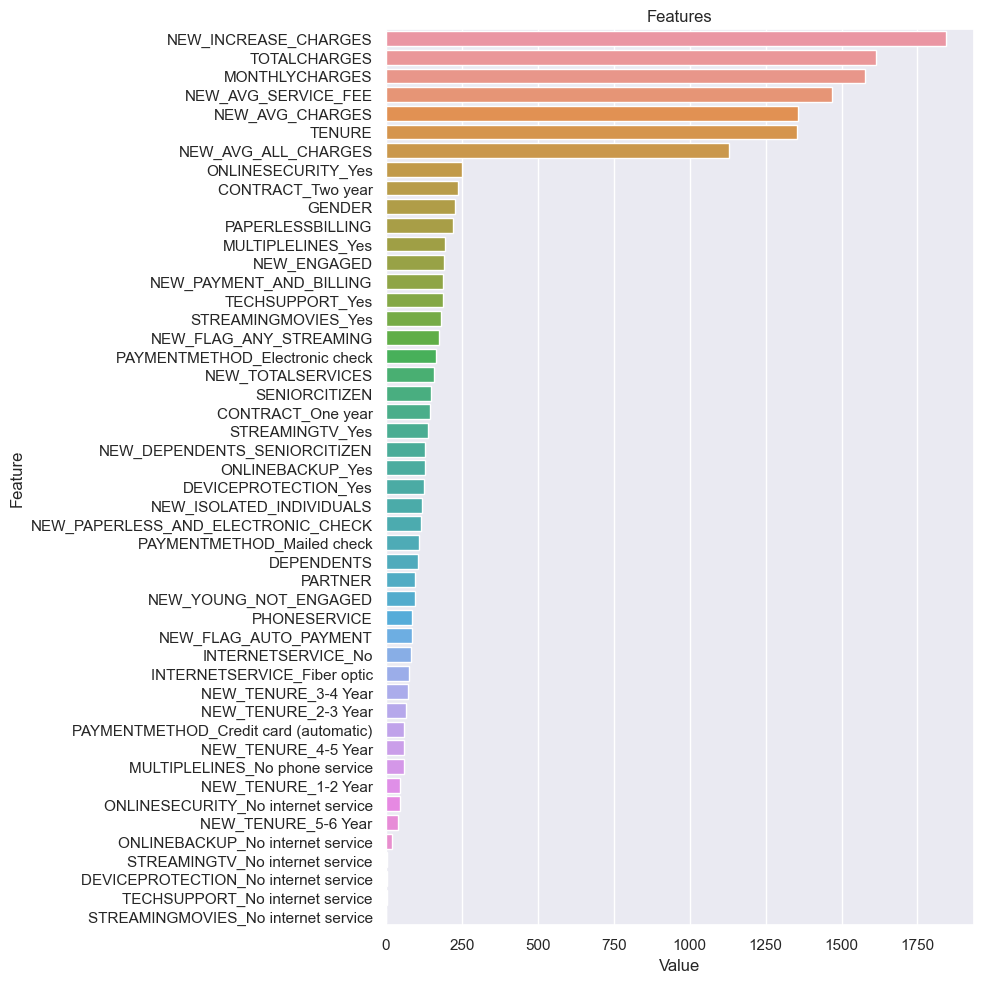

In [706]:
plot_importance(lgbm_final, X)

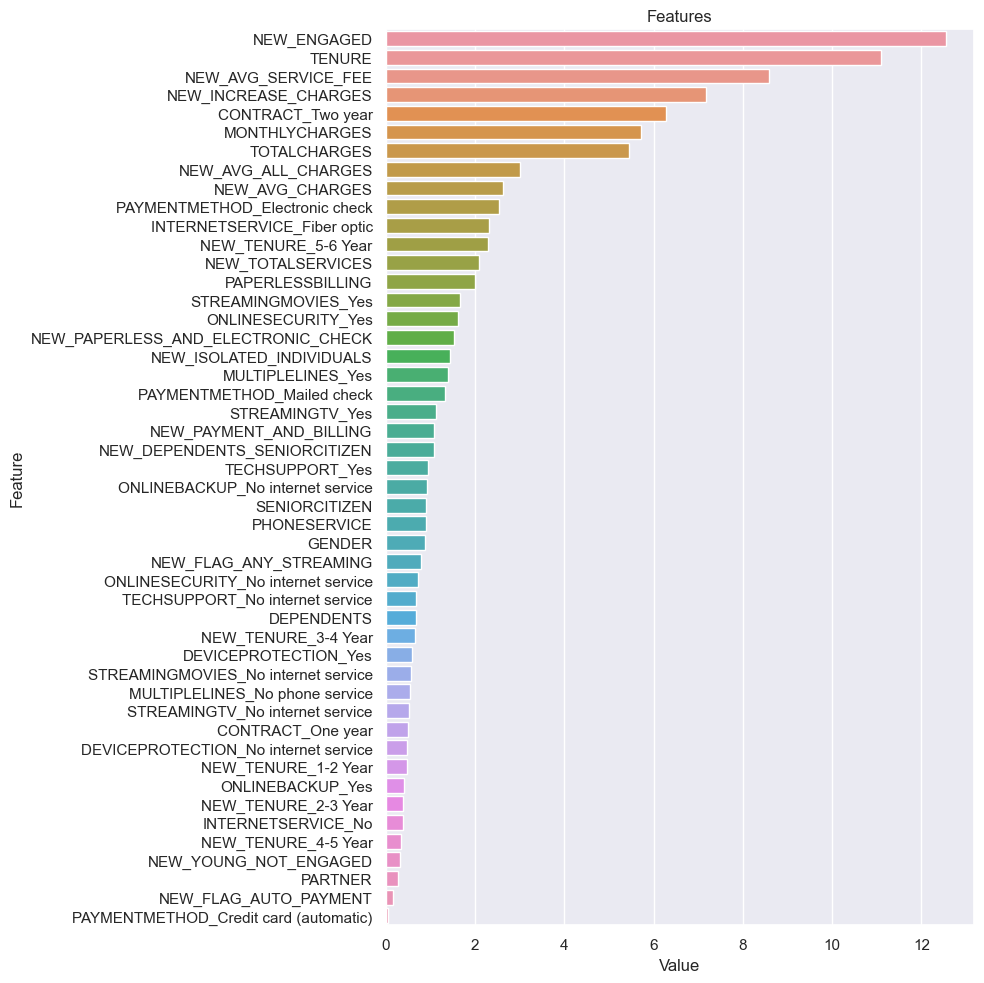

In [707]:
plot_importance(catboost_final, X)